## RNN for Human Activity Recognition - 2D Pose Input

This experiment is the classification of human activities using a 2D pose time series dataset and an LSTM RNN.
The idea is to prove the concept that using a series of 2D poses, rather than 3D poses or a raw 2D images, can produce an accurate estimation of the behaviour of a person or animal.
This is a step towards creating a method of classifying an animal's current behaviour state and predicting it's likely next state, allowing for better interaction with an autonomous mobile robot.

## Objectives

The aims of this experiment are:

-  To determine if 2D pose has comparable accuracy to 3D pose for use in activity recognition. This would allow the use of RGB only cameras for human and animal pose estimation, as opposed to RGBD or a large motion capture dataset.


- To determine if  2D pose has comparable accuracy to using raw RGB images for use in activity recognition. This is based on the idea that limiting the input feature vector can help to deal with a limited dataset, as is likely to occur in animal activity recognition, by allowing for a smaller model to be used (citation required).


- To verify the concept for use in future works involving behaviour prediction from motion in 2D images.

The network used in this experiment is based on that of Guillaume Chevalier, 'LSTMs for Human Activity Recognition, 2016'  https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition, available under the MIT License.
Notable changes that have been made (other than accounting for dataset sizes) are:
 - Adapting for use with a large dataset ordered by class, using random sampling without replacement for mini-batch.  
 This allows for use of smaller batch sizes when using a dataset ordered by class. "It has been observed in practice that when using a larger batch there is a significant degradation in the quality of the model, as measured by its ability to generalize"  
      _N.S Keskar, D. Mudigere, et al, 'On Large-Batch Training for Deep Learning: Generalization Gap and Sharp 
      Minima', ICLR 2017_ https://arxiv.org/abs/1609.04836
      
 - Exponentially decaying learning rate implemented



## Dataset overview

The dataset consists of pose estimations, made using the software OpenPose (https://github.com/CMU-Perceptual-Computing-Lab/openpose's) on a subset of the Berkeley Multimodal Human Action Database (MHAD) dataset http://tele-immersion.citris-uc.org/berkeley_mhad.

This dataset is comprised of 12 subjects doing the following 6 actions for 5 repetitions, filmed from 4 angles, repeated 5 times each.  

- JUMPING,
- JUMPING_JACKS,
- BOXING,
- WAVING_2HANDS,
- WAVING_1HAND,
- CLAPPING_HANDS.

In total, there are 1438 videos (2 were missing) made up of 211200 individual frames.

The below image is an example of the 4 camera views during the 'boxing' action for subject 1

![alt text](images/boxing_all_views.gif.png "Title")

The input for the LSTM is the 2D position of 18 joints across a timeseries of frames numbering n_steps (window-width), with an associated class label for the frame series.  
A single frame's input (where j refers to a joint) is stored as:

[  j0_x,  j0_y, j1_x, j1_y , j2_x, j2_y, j3_x, j3_y, j4_x, j4_y, j5_x, j5_y, j6_x, j6_y, j7_x, j7_y, j8_x, j8_y, j9_x, j9_y, j10_x, j10_y, j11_x, j11_y, j12_x, j12_y, j13_x, j13_y, j14_x, j14_y, j15_x, j15_y, j16_x, j16_y, j17_x, j17_y ]

For the following experiment, very little preprocessing has been done to the dataset.  
The following steps were taken:
1. openpose run on individual frames, for each subject, action and view, outputting JSON of 18 joint x and y position keypoints and accuracies per frame
2. JSONs converted into txt format, keeping only x and y positions of each frame, action being performed during frame, and order of frames. This is used to create a database of associated activity class number and corresponding series of joint 2D positions
3. No further prepossessing was performed.  

In some cases, multiple people were detected in each frame, in which only the first detection was used.

The data has not been normalised with regards to subject position in the frame, motion across frame (if any), size of the subject, speed of action etc. It is essentially the raw 2D position of each joint viewed from a stationary camera.  
In many cases, individual joints were not located and a position of [0.0,0.0] was given for that joint

A summary of the dataset used for input is:

 - 211200 individual images 
 - n_steps = 32 frames (~=1.5s at 22Hz)
 - Images with noisy pose detection (detection of >=2 people) = 5132  
 - Training_split = 0.8
 - Overlap = 0.8125 (26 / 32) ie 26 frame overlap
   - Length X_train = 22625 * 32 frames
   - Length X_test = 5751 * 32 frames
   
Note that their is no overlap between test and train sets, which were seperated by activity repetition entirely, before creating the 26 of 32 frame overlap.




## Training and Results below: 
Training took approximately 4 mins running on a single GTX1080Ti, and was run for 22,000,000ish iterations with a batch size of 5000  (600 epochs)


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import random
from random import randint
import time
import os

## Preparing dataset:

In [2]:
# Useful Constants

# Output classes to learn how to classify
# LABELS = [    
#     "JUMPING",
#     "JUMPING_JACKS",
# #     "BOXING",
#     "WAVING_2HANDS",
#     "WAVING_1HAND",
#     "CLAPPING_HANDS"
# ] 

# LABELS = [    
#     "GO_IN",
#     "GO_OUT",
#     "WALK_LEFT",
#     "WALK_RIGHT"
# ] 

# LABELS = [    
#     "normal", "anomaly"
# ] 

LABELS = [
    "jalan_DR", "jalan_UR", "jalan_DL", "jalan_UL",
    "sapu_DR", "sapu_UR", "sapu_DL", "sapu_UL",
    "suspicious_DR", "suspicious_UR", "suspicious_DL", "suspicious_UL",
    "out_door_SE", "out_door_SW", "in_door_SE", "in_door_SW",
    "idle"
]

# LABELS = [    
#     "jalan_NE", "jalan_NW", "jalan_SE", "jalan_SW",
#     "menyapu_NE", "menyapu_NW", "menyapu_SE", "menyapu_SW",
#     "barang_NE", "barang_NW", "barang_SE", "barang_SW",
#     "diam_NE", "diam_NW", "diam_SE", "diam_SW"
# ] 

# DATASET_PATH = "data/HAR_pose_activities/database/"
# DATASET_PATH = "data/HAR_pose_activities/database/Training Default/"

# DATASET_PATH = "data/Overlap_fixed4_separated/"

DATASET_PATH = "data/DirectNO/Normalize/"

X_train_path = DATASET_PATH + "X_train.txt"
X_test_path = DATASET_PATH + "X_test.txt"
# X_test_path = "utilities/something/something.txt"

y_train_path = DATASET_PATH + "Y_train.txt"
y_test_path = DATASET_PATH + "Y_test.txt"

# n_steps = 32 # 32 timesteps per series
# n_steps = 1

# n_steps = 5
n_steps = 8

In [3]:

# Load the networks inputs

def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    blocks = int(len(X_) / n_steps)
    
    X_ = np.array(np.split(X_,blocks))

    return X_ 

# Load the networks outputs

def load_y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # for 0-based indexing 
    return y_ - 1

X_train = load_X(X_train_path)
X_test = load_X(X_test_path)
#print X_test

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)
# proof that it actually works for the skeptical: replace labelled classes with random classes to train on
#for i in range(len(y_train)):
#    y_train[i] = randint(0, 5)


## Set Parameters:


In [4]:
# Input Data 

training_data_count = len(X_train)  # 4519 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 1197 test series
n_input = len(X_train[0][0])  # num input parameters per timestep

n_hidden = 36 # Hidden layer num of features
# n_classes = 6 
n_classes = len(LABELS)

#updated for learning-rate decay
# calculated as: decayed_learning_rate = init_learning_rate * decay_rate ^ (global_step / decay_steps)
decaying_learning_rate = True
learning_rate = 0.0025 #used if decaying_learning_rate set to False

init_learning_rate = 0.005
# init_learning_rate = 0.00015

decay_rate = 0.96 #the base of the exponential in the decay
decay_steps = 100000 #used in decay every 60000 steps with a base of 0.96

global_step = tf.Variable(0, trainable=False)
lambda_loss_amount = 0.0015

# training_iters = training_data_count *300  # Loop 300 times on the dataset, ie 300 epochs
# training_iters = training_data_count *60
# training_iters = training_data_count *120
# training_iters = training_data_count *1
# batch_size = 5
batch_size = 64
# batch_size = 512
display_iter = batch_size*8  # To show test set accuracy during training

print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_train.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("\nThe dataset has not been preprocessed, is not normalised etc")




(X shape, y shape, every X's mean, every X's standard deviation)
(1382, 8, 36) (2470, 1) -7.722059e-10 25.582153

The dataset has not been preprocessed, is not normalised etc


## Utility functions for training:

In [5]:
def LSTM_RNN(_X, _weights, _biases):
    # model architecture based on "guillaume-chevalier" and "aymericdamien" under the MIT license.

    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    _X = tf.reshape(_X, [-1, n_input])   
    # Rectifies Linear Unit activation function used
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # A single output is produced, in style of "many to one" classifier, refer to http://karpathy.github.io/2015/05/21/rnn-effectiveness/ for details
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, _labels, _unsampled, batch_size):
    # Fetch a "batch_size" amount of data and labels from "(X|y)_train" data. 
    # Elements of each batch are chosen randomly, without replacement, from X_train with corresponding label from Y_train
    # unsampled_indices keeps track of sampled data ensuring non-replacement. Resets when remaining datapoints < batch_size    
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    batch_labels = np.empty((batch_size,1)) 

    for i in range(batch_size):
        # Loop index
        # index = random sample from _unsampled (indices)
        index = random.choice(_unsampled)
        batch_s[i] = _train[index] 
        batch_labels[i] = _labels[index]
        
        _unsampled = list(_unsampled)
        
        _unsampled.remove(index)


    return batch_s, batch_labels, _unsampled


def one_hot(y_):
    # One hot encoding of the network outputs
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS



## Build the network:

In [6]:
# for _ in range(3):
#     tf.reset_default_graph()
#     var = tf.Variable(0)
#     with tf.Session() as session:
#         session.run(tf.global_variables_initializer())
#         print(len(session.graph._nodes_by_name.keys()))

In [7]:

# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
if decaying_learning_rate:
    learning_rate = tf.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)


#decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps) #exponentially decayed learning rate
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost,global_step=global_step) # Adam Optimizer

# correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
# accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))



Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [8]:
print(biases)
print(weights['hidden'])

{'hidden': <tf.Variable 'Variable_3:0' shape=(36,) dtype=float32_ref>, 'out': <tf.Variable 'Variable_4:0' shape=(17,) dtype=float32_ref>}
<tf.Variable 'Variable_1:0' shape=(36, 36) dtype=float32_ref>


In [9]:
# if decaying_learning_rate:
#     learning_rate = tf.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)

## Train the network:

In [10]:
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()

sess.run(init)

In [11]:
# training_iters = training_data_count *120
# training_iters = training_data_count *5120
# training_iters = training_data_count *2560
# training_iters = training_data_count *1024
training_iters = training_data_count *2046
# training_iters = training_data_count *1024
# training_iters = training_data_count *5120

#create saver before training
# saver = tf.train.Saver()
saver = tf.train.Saver(var_list={'wh':weights['hidden'], 'wo':weights['out'], 'bh':biases['hidden'], 'bo':biases['out']})
load = False
train = True
update = True

#check if you want to retrain or import a saved model
if load:
    saver.restore(sess, DATASET_PATH + "model.ckpt")
    print("Model restored.")

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [12]:
# Perform Training steps with "batch_size" amount of data at each loop. 
# Elements of each batch are chosen randomly, without replacement, from X_train, 
# restarting when remaining datapoints < batch_size
step = 1
time_start = time.time()
unsampled_indices = range(0,len(X_train))

if not train:
    
    # only perform testing - on training set
    loss, acc = sess.run(
        [cost, accuracy], 
        feed_dict={
            x: X_train,
            y: one_hot(y_train)
        }
    )
    
    print("PERFORMANCE ON TRAIN SET:             " + \
          "Batch Loss = {}".format(loss) + \
          ", Accuracy = {}".format(acc))
    
    # only perform testing - on test set
    loss, acc = sess.run(
        [cost, accuracy], 
        feed_dict={
            x: X_test,
            y: one_hot(y_test)
        }
    )
    
    print("PERFORMANCE ON TEST SET:             " + \
          "Batch Loss = {}".format(loss) + \
          ", Accuracy = {}".format(acc))

while train and (step * batch_size <= training_iters):
    #print (sess.run(learning_rate)) #decaying learning rate
    #print (sess.run(global_step)) # global number of iterations
    if len(unsampled_indices) < batch_size:
        unsampled_indices = range(0,len(X_train)) 
    batch_xs, raw_labels, unsampled_indicies = extract_batch_size(X_train, y_train, unsampled_indices, batch_size)
    batch_ys = one_hot(raw_labels)
    # check that encoded output is same length as num_classes, if not, pad it 
    if len(batch_ys[0]) < n_classes:
        temp_ys = np.zeros((batch_size, n_classes))
        temp_ys[:batch_ys.shape[0],:batch_ys.shape[1]] = batch_ys
        batch_ys = temp_ys
       
    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print("Iter #" + str(step*batch_size) + \
              ":  Learning rate = " + "{:.6f}".format(sess.run(learning_rate)) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET:             " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy_fin, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy_fin)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy_fin))
time_stop = time.time()
print("TOTAL TIME:  {}".format(time_stop - time_start))

Iter #64:  Learning rate = 0.005000:   Batch Loss = 6.251019, Accuracy = 0.03125
PERFORMANCE ON TEST SET:             Batch Loss = 5.608214378356934, Accuracy = 0.10485830157995224
Iter #512:  Learning rate = 0.005000:   Batch Loss = 4.608506, Accuracy = 0.25
PERFORMANCE ON TEST SET:             Batch Loss = 4.487692832946777, Accuracy = 0.3085020184516907
Iter #1024:  Learning rate = 0.005000:   Batch Loss = 4.212497, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 4.142374038696289, Accuracy = 0.3360323905944824
Iter #1536:  Learning rate = 0.005000:   Batch Loss = 3.697629, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 3.9438347816467285, Accuracy = 0.41093116998672485
Iter #2048:  Learning rate = 0.005000:   Batch Loss = 3.533481, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 3.75866436958313, Accuracy = 0.4663967490196228
Iter #2560:  Learning rate = 0.005000:   Batch Loss = 3.390174, Accuracy = 0.5625
PERFORMANCE O

Iter #23552:  Learning rate = 0.005000:   Batch Loss = 2.134220, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 2.408886432647705, Accuracy = 0.6441295742988586
Iter #24064:  Learning rate = 0.005000:   Batch Loss = 1.958626, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 2.316964864730835, Accuracy = 0.6785424947738647
Iter #24576:  Learning rate = 0.005000:   Batch Loss = 2.011322, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 2.344590663909912, Accuracy = 0.670040488243103
Iter #25088:  Learning rate = 0.005000:   Batch Loss = 1.927314, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 2.337568759918213, Accuracy = 0.6744939088821411
Iter #25600:  Learning rate = 0.005000:   Batch Loss = 1.965910, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 2.2424018383026123, Accuracy = 0.6842105388641357
Iter #26112:  Learning rate = 0.005000:   Batch Loss = 1.808360, Accuracy = 0.828125

Iter #47616:  Learning rate = 0.005000:   Batch Loss = 1.574947, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.872042179107666, Accuracy = 0.7238866686820984
Iter #48128:  Learning rate = 0.005000:   Batch Loss = 1.515374, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8799481391906738, Accuracy = 0.7190283536911011
Iter #48640:  Learning rate = 0.005000:   Batch Loss = 1.351109, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.798417568206787, Accuracy = 0.7489878535270691
Iter #49152:  Learning rate = 0.005000:   Batch Loss = 1.508841, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8329895734786987, Accuracy = 0.7384615540504456
Iter #49664:  Learning rate = 0.005000:   Batch Loss = 1.446384, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7683911323547363, Accuracy = 0.7538461685180664
Iter #50176:  Learning rate = 0.005000:   Batch Loss = 1.376636, Accuracy = 0.875
P

Iter #70656:  Learning rate = 0.005000:   Batch Loss = 1.156065, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.590993881225586, Accuracy = 0.7724696397781372
Iter #71168:  Learning rate = 0.005000:   Batch Loss = 1.160572, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5642640590667725, Accuracy = 0.7842105031013489
Iter #71680:  Learning rate = 0.005000:   Batch Loss = 1.121613, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5792391300201416, Accuracy = 0.7781376242637634
Iter #72192:  Learning rate = 0.005000:   Batch Loss = 1.071214, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5893107652664185, Accuracy = 0.7712550759315491
Iter #72704:  Learning rate = 0.005000:   Batch Loss = 1.043845, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5432472229003906, Accuracy = 0.7838056683540344
Iter #73216:  Learning rate = 0.005000:   Batch Loss = 1.048110, Accuracy = 0

Iter #94720:  Learning rate = 0.005000:   Batch Loss = 0.911665, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4073439836502075, Accuracy = 0.7866396903991699
Iter #95232:  Learning rate = 0.005000:   Batch Loss = 0.832390, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3592885732650757, Accuracy = 0.8020243048667908
Iter #95744:  Learning rate = 0.005000:   Batch Loss = 0.863103, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3945956230163574, Accuracy = 0.7935222387313843
Iter #96256:  Learning rate = 0.005000:   Batch Loss = 0.866413, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3888871669769287, Accuracy = 0.7902833819389343
Iter #96768:  Learning rate = 0.005000:   Batch Loss = 0.959062, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4139113426208496, Accuracy = 0.7809716463088989
Iter #97280:  Learning rate = 0.005000:   Batch Loss = 0.997495, Accuracy = 0

Iter #117760:  Learning rate = 0.004800:   Batch Loss = 0.763807, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2662043571472168, Accuracy = 0.8165991902351379
Iter #118272:  Learning rate = 0.004800:   Batch Loss = 0.747216, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2793773412704468, Accuracy = 0.8080971837043762
Iter #118784:  Learning rate = 0.004800:   Batch Loss = 0.825872, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2635509967803955, Accuracy = 0.8121457695960999
Iter #119296:  Learning rate = 0.004800:   Batch Loss = 0.708842, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2672157287597656, Accuracy = 0.8040485978126526
Iter #119808:  Learning rate = 0.004800:   Batch Loss = 0.753957, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2683919668197632, Accuracy = 0.8008097410202026
Iter #120320:  Learning rate = 0.004800:   Batch Loss = 0.751633, Accurac

Iter #140800:  Learning rate = 0.004800:   Batch Loss = 0.741117, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.307788610458374, Accuracy = 0.7821862101554871
Iter #141312:  Learning rate = 0.004800:   Batch Loss = 0.730210, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2810022830963135, Accuracy = 0.794331967830658
Iter #141824:  Learning rate = 0.004800:   Batch Loss = 0.754376, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2824759483337402, Accuracy = 0.7894737124443054
Iter #142336:  Learning rate = 0.004800:   Batch Loss = 0.729484, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3117396831512451, Accuracy = 0.7748987674713135
Iter #142848:  Learning rate = 0.004800:   Batch Loss = 0.779865, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2781003713607788, Accuracy = 0.7850202322006226
Iter #143360:  Learning rate = 0.004800:   Batch Loss = 0.763059, Accuracy =

Iter #164864:  Learning rate = 0.004800:   Batch Loss = 0.636766, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.159737229347229, Accuracy = 0.8222672343254089
Iter #165376:  Learning rate = 0.004800:   Batch Loss = 0.688199, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1495320796966553, Accuracy = 0.8234817981719971
Iter #165888:  Learning rate = 0.004800:   Batch Loss = 0.630473, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.1218461990356445, Accuracy = 0.8327935338020325
Iter #166400:  Learning rate = 0.004800:   Batch Loss = 0.603362, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.130960464477539, Accuracy = 0.8348178267478943
Iter #166912:  Learning rate = 0.004800:   Batch Loss = 0.647278, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.151009440422058, Accuracy = 0.8340080976486206
Iter #167424:  Learning rate = 0.004800:   Batch Loss = 0.623716, Accuracy = 0.984375
PER

PERFORMANCE ON TEST SET:             Batch Loss = 1.1394071578979492, Accuracy = 0.8036437034606934
Iter #187904:  Learning rate = 0.004800:   Batch Loss = 0.670887, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.143982172012329, Accuracy = 0.8141700625419617
Iter #188416:  Learning rate = 0.004800:   Batch Loss = 0.733974, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1784287691116333, Accuracy = 0.8068826198577881
Iter #188928:  Learning rate = 0.004800:   Batch Loss = 0.650930, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1217962503433228, Accuracy = 0.8242915272712708
Iter #189440:  Learning rate = 0.004800:   Batch Loss = 0.604375, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1616590023040771, Accuracy = 0.8060728907585144
Iter #189952:  Learning rate = 0.004800:   Batch Loss = 0.611427, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1272754669189453, Accur

Iter #210944:  Learning rate = 0.004608:   Batch Loss = 0.568868, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.08102548122406, Accuracy = 0.8246963620185852
Iter #211456:  Learning rate = 0.004608:   Batch Loss = 0.578462, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.104038119316101, Accuracy = 0.8089068531990051
Iter #211968:  Learning rate = 0.004608:   Batch Loss = 0.624365, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0907224416732788, Accuracy = 0.8255060911178589
Iter #212480:  Learning rate = 0.004608:   Batch Loss = 0.586609, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1963112354278564, Accuracy = 0.7850202322006226
Iter #212992:  Learning rate = 0.004608:   Batch Loss = 0.670515, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1676064729690552, Accuracy = 0.7955465316772461
Iter #213504:  Learning rate = 0.004608:   Batch Loss = 0.654249, Accuracy =

Iter #233984:  Learning rate = 0.004608:   Batch Loss = 0.658615, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1926774978637695, Accuracy = 0.7676113247871399
Iter #234496:  Learning rate = 0.004608:   Batch Loss = 0.614190, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1295055150985718, Accuracy = 0.7914980053901672
Iter #235008:  Learning rate = 0.004608:   Batch Loss = 0.638352, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1580041646957397, Accuracy = 0.7959514260292053
Iter #235520:  Learning rate = 0.004608:   Batch Loss = 0.572183, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1431084871292114, Accuracy = 0.7971659898757935
Iter #236032:  Learning rate = 0.004608:   Batch Loss = 0.629573, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.083419919013977, Accuracy = 0.8226720690727234
Iter #236544:  Learning rate = 0.004608:   Batch Loss = 0.547116, Accuracy =

PERFORMANCE ON TEST SET:             Batch Loss = 0.9763212203979492, Accuracy = 0.8481781482696533
Iter #258048:  Learning rate = 0.004608:   Batch Loss = 0.473709, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.9995445013046265, Accuracy = 0.8441295623779297
Iter #258560:  Learning rate = 0.004608:   Batch Loss = 0.496147, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9938870072364807, Accuracy = 0.8396761417388916
Iter #259072:  Learning rate = 0.004608:   Batch Loss = 0.481284, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.9823373556137085, Accuracy = 0.8453441262245178
Iter #259584:  Learning rate = 0.004608:   Batch Loss = 0.451037, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.9861012697219849, Accuracy = 0.8384615182876587
Iter #260096:  Learning rate = 0.004608:   Batch Loss = 0.488178, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.013047695159912, Accuracy = 0.83967614

Iter #280576:  Learning rate = 0.004608:   Batch Loss = 0.629692, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0775244235992432, Accuracy = 0.8024291396141052
Iter #281088:  Learning rate = 0.004608:   Batch Loss = 0.598880, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0589309930801392, Accuracy = 0.8190283179283142
Iter #281600:  Learning rate = 0.004608:   Batch Loss = 0.525295, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.089963674545288, Accuracy = 0.7979757189750671
Iter #282112:  Learning rate = 0.004608:   Batch Loss = 0.616038, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0623998641967773, Accuracy = 0.8153846263885498
Iter #282624:  Learning rate = 0.004608:   Batch Loss = 0.531464, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1118748188018799, Accuracy = 0.7979757189750671
Iter #283136:  Learning rate = 0.004608:   Batch Loss = 0.590267, Accur

PERFORMANCE ON TEST SET:             Batch Loss = 1.02077317237854, Accuracy = 0.8311740756034851
Iter #304128:  Learning rate = 0.004424:   Batch Loss = 0.536557, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0192004442214966, Accuracy = 0.8348178267478943
Iter #304640:  Learning rate = 0.004424:   Batch Loss = 0.452292, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9956603050231934, Accuracy = 0.840080976486206
Iter #305152:  Learning rate = 0.004424:   Batch Loss = 0.464157, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9785493612289429, Accuracy = 0.8425101041793823
Iter #305664:  Learning rate = 0.004424:   Batch Loss = 0.479485, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9542885422706604, Accuracy = 0.8449392914772034
Iter #306176:  Learning rate = 0.004424:   Batch Loss = 0.444658, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.9590650200843811, Accuracy

Iter #327680:  Learning rate = 0.004424:   Batch Loss = 0.380318, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.883296549320221, Accuracy = 0.8514170050621033
Iter #328192:  Learning rate = 0.004424:   Batch Loss = 0.374998, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.850621223449707, Accuracy = 0.8672064542770386
Iter #328704:  Learning rate = 0.004424:   Batch Loss = 0.408819, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8460096716880798, Accuracy = 0.8643724918365479
Iter #329216:  Learning rate = 0.004424:   Batch Loss = 0.368324, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.8688255548477173, Accuracy = 0.8477732539176941
Iter #329728:  Learning rate = 0.004424:   Batch Loss = 0.375120, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.8648420572280884, Accuracy = 0.8514170050621033
Iter #330240:  Learning rate = 0.004424:   Batch Loss = 0.391575, Accuracy = 1.0
PERFORMANCE

Iter #351232:  Learning rate = 0.004424:   Batch Loss = 0.593488, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0072124004364014, Accuracy = 0.8214575052261353
Iter #351744:  Learning rate = 0.004424:   Batch Loss = 0.801647, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.057780146598816, Accuracy = 0.8040485978126526
Iter #352256:  Learning rate = 0.004424:   Batch Loss = 0.615077, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.042114496231079, Accuracy = 0.8072874546051025
Iter #352768:  Learning rate = 0.004424:   Batch Loss = 0.624153, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0228402614593506, Accuracy = 0.8190283179283142
Iter #353280:  Learning rate = 0.004424:   Batch Loss = 0.561744, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.046412706375122, Accuracy = 0.8085020184516907
Iter #353792:  Learning rate = 0.004424:   Batch Loss = 0.482996, Accuracy = 0

Iter #374272:  Learning rate = 0.004424:   Batch Loss = 0.396024, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.9068498611450195, Accuracy = 0.852226734161377
Iter #374784:  Learning rate = 0.004424:   Batch Loss = 0.409816, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8931671380996704, Accuracy = 0.8526315689086914
Iter #375296:  Learning rate = 0.004424:   Batch Loss = 0.408013, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.940041184425354, Accuracy = 0.8364372253417969
Iter #375808:  Learning rate = 0.004424:   Batch Loss = 0.404114, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.8672125339508057, Accuracy = 0.8651821613311768
Iter #376320:  Learning rate = 0.004424:   Batch Loss = 0.404333, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.8840186595916748, Accuracy = 0.8506072759628296
Iter #376832:  Learning rate = 0.004424:   Batch Loss = 0.394342, Accuracy = 1.0
PERFORMANCE

Iter #398336:  Learning rate = 0.004424:   Batch Loss = 0.369109, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.869048535823822, Accuracy = 0.8497975468635559
Iter #398848:  Learning rate = 0.004424:   Batch Loss = 0.350239, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.8417965173721313, Accuracy = 0.8526315689086914
Iter #399360:  Learning rate = 0.004424:   Batch Loss = 0.367009, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8451970219612122, Accuracy = 0.8550607562065125
Iter #399872:  Learning rate = 0.004424:   Batch Loss = 0.348010, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.8713749647140503, Accuracy = 0.843319833278656
Iter #400384:  Learning rate = 0.004247:   Batch Loss = 0.388902, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9731937646865845, Accuracy = 0.8153846263885498
Iter #400896:  Learning rate = 0.004247:   Batch Loss = 0.500430, Accuracy = 0.953125
P

PERFORMANCE ON TEST SET:             Batch Loss = 0.9454336762428284, Accuracy = 0.835627555847168
Iter #421888:  Learning rate = 0.004247:   Batch Loss = 0.428544, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9327970743179321, Accuracy = 0.8352226614952087
Iter #422400:  Learning rate = 0.004247:   Batch Loss = 0.584956, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.900456428527832, Accuracy = 0.843319833278656
Iter #422912:  Learning rate = 0.004247:   Batch Loss = 0.403456, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9241470694541931, Accuracy = 0.8368421196937561
Iter #423424:  Learning rate = 0.004247:   Batch Loss = 0.405611, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.9028900861740112, Accuracy = 0.8477732539176941
Iter #423936:  Learning rate = 0.004247:   Batch Loss = 0.431875, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8792833089828491, Accuracy = 

PERFORMANCE ON TEST SET:             Batch Loss = 0.9991804361343384, Accuracy = 0.8085020184516907
Iter #444928:  Learning rate = 0.004247:   Batch Loss = 0.691998, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9956021308898926, Accuracy = 0.8125506043434143
Iter #445440:  Learning rate = 0.004247:   Batch Loss = 0.485823, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0212732553482056, Accuracy = 0.8040485978126526
Iter #445952:  Learning rate = 0.004247:   Batch Loss = 0.482319, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0210487842559814, Accuracy = 0.8109311461448669
Iter #446464:  Learning rate = 0.004247:   Batch Loss = 0.524835, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9787307977676392, Accuracy = 0.8093117475509644
Iter #446976:  Learning rate = 0.004247:   Batch Loss = 0.399776, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.9433467388153076, Accura

Iter #468480:  Learning rate = 0.004247:   Batch Loss = 0.311040, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7306572198867798, Accuracy = 0.8813765048980713
Iter #468992:  Learning rate = 0.004247:   Batch Loss = 0.310488, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7311428785324097, Accuracy = 0.8829959630966187
Iter #469504:  Learning rate = 0.004247:   Batch Loss = 0.308709, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7327255010604858, Accuracy = 0.8838056921958923
Iter #470016:  Learning rate = 0.004247:   Batch Loss = 0.303791, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7291254997253418, Accuracy = 0.8850202560424805
Iter #470528:  Learning rate = 0.004247:   Batch Loss = 0.307411, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7334864139556885, Accuracy = 0.8805667757987976
Iter #471040:  Learning rate = 0.004247:   Batch Loss = 0.304216, Accuracy = 1.0
PERFORMANCE ON

PERFORMANCE ON TEST SET:             Batch Loss = 0.7133756279945374, Accuracy = 0.873279333114624
Iter #492544:  Learning rate = 0.004247:   Batch Loss = 0.267329, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7084590792655945, Accuracy = 0.8712550401687622
Iter #493056:  Learning rate = 0.004247:   Batch Loss = 0.275160, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7116050720214844, Accuracy = 0.873279333114624
Iter #493568:  Learning rate = 0.004247:   Batch Loss = 0.261130, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7133979797363281, Accuracy = 0.8720647692680359
Iter #494080:  Learning rate = 0.004247:   Batch Loss = 0.258397, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7049367427825928, Accuracy = 0.8773279190063477
Iter #494592:  Learning rate = 0.004247:   Batch Loss = 0.264871, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7092781662940979, Accuracy = 0.87489879131317

PERFORMANCE ON TEST SET:             Batch Loss = 0.8572050333023071, Accuracy = 0.8384615182876587
Iter #515584:  Learning rate = 0.004077:   Batch Loss = 0.384838, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8666403293609619, Accuracy = 0.848987877368927
Iter #516096:  Learning rate = 0.004077:   Batch Loss = 0.384071, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.8653013706207275, Accuracy = 0.840080976486206
Iter #516608:  Learning rate = 0.004077:   Batch Loss = 0.464570, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8705877065658569, Accuracy = 0.8417003750801086
Iter #517120:  Learning rate = 0.004077:   Batch Loss = 0.387449, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.859021008014679, Accuracy = 0.8408907055854797
Iter #517632:  Learning rate = 0.004077:   Batch Loss = 0.475595, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8573263883590698, Accuracy =

Iter #538624:  Learning rate = 0.004077:   Batch Loss = 0.422086, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8998948335647583, Accuracy = 0.8323886394500732
Iter #539136:  Learning rate = 0.004077:   Batch Loss = 0.377077, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8604769110679626, Accuracy = 0.8457489609718323
Iter #539648:  Learning rate = 0.004077:   Batch Loss = 0.378474, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8732361793518066, Accuracy = 0.8408907055854797
Iter #540160:  Learning rate = 0.004077:   Batch Loss = 0.346249, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.8823692798614502, Accuracy = 0.8404858112335205
Iter #540672:  Learning rate = 0.004077:   Batch Loss = 0.372937, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8758158683776855, Accuracy = 0.8473684191703796
Iter #541184:  Learning rate = 0.004077:   Batch Loss = 0.392278, Accuracy = 

PERFORMANCE ON TEST SET:             Batch Loss = 0.7072543501853943, Accuracy = 0.8785424828529358
Iter #563200:  Learning rate = 0.004077:   Batch Loss = 0.267217, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6954082250595093, Accuracy = 0.876518189907074
Iter #563712:  Learning rate = 0.004077:   Batch Loss = 0.267549, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6896581649780273, Accuracy = 0.878947377204895
Iter #564224:  Learning rate = 0.004077:   Batch Loss = 0.260955, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6936594247817993, Accuracy = 0.8801619410514832
Iter #564736:  Learning rate = 0.004077:   Batch Loss = 0.257330, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.683647632598877, Accuracy = 0.882186233997345
Iter #565248:  Learning rate = 0.004077:   Batch Loss = 0.266911, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6850357055664062, Accuracy = 0.8773279190063477

PERFORMANCE ON TEST SET:             Batch Loss = 0.9527662396430969, Accuracy = 0.8093117475509644
Iter #586240:  Learning rate = 0.004077:   Batch Loss = 0.607510, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9773313999176025, Accuracy = 0.807692289352417
Iter #586752:  Learning rate = 0.004077:   Batch Loss = 0.478281, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9536212086677551, Accuracy = 0.8093117475509644
Iter #587264:  Learning rate = 0.004077:   Batch Loss = 0.525533, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9432265758514404, Accuracy = 0.810121476650238
Iter #587776:  Learning rate = 0.004077:   Batch Loss = 0.482015, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0055649280548096, Accuracy = 0.7979757189750671
Iter #588288:  Learning rate = 0.004077:   Batch Loss = 0.572821, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9261223673820496, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 0.7188913822174072, Accuracy = 0.876518189907074
Iter #610304:  Learning rate = 0.003914:   Batch Loss = 0.271320, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7287687063217163, Accuracy = 0.8744939565658569
Iter #610816:  Learning rate = 0.003914:   Batch Loss = 0.272037, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7297110557556152, Accuracy = 0.8712550401687622
Iter #611328:  Learning rate = 0.003914:   Batch Loss = 0.271818, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7234479784965515, Accuracy = 0.8736842274665833
Iter #611840:  Learning rate = 0.003914:   Batch Loss = 0.269402, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7141544222831726, Accuracy = 0.8761133551597595
Iter #612352:  Learning rate = 0.003914:   Batch Loss = 0.270418, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7141519784927368, Accuracy = 0.8769230842590

Iter #633344:  Learning rate = 0.003914:   Batch Loss = 0.229640, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6756324768066406, Accuracy = 0.8769230842590332
Iter #633856:  Learning rate = 0.003914:   Batch Loss = 0.233304, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6706677079200745, Accuracy = 0.8777328133583069
Iter #634368:  Learning rate = 0.003914:   Batch Loss = 0.239632, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6753736734390259, Accuracy = 0.8785424828529358
Iter #634880:  Learning rate = 0.003914:   Batch Loss = 0.232687, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6744548678398132, Accuracy = 0.8773279190063477
Iter #635392:  Learning rate = 0.003914:   Batch Loss = 0.232623, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.670535147190094, Accuracy = 0.8773279190063477
Iter #635904:  Learning rate = 0.003914:   Batch Loss = 0.231050, Accuracy = 1.0
PERFORMANCE ON 

Iter #656896:  Learning rate = 0.003914:   Batch Loss = 0.461827, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9007564783096313, Accuracy = 0.8230769038200378
Iter #657408:  Learning rate = 0.003914:   Batch Loss = 0.513701, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9560648202896118, Accuracy = 0.8113360404968262
Iter #657920:  Learning rate = 0.003914:   Batch Loss = 0.485812, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9404669404029846, Accuracy = 0.8105263113975525
Iter #658432:  Learning rate = 0.003914:   Batch Loss = 0.470799, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8561183214187622, Accuracy = 0.8376518487930298
Iter #658944:  Learning rate = 0.003914:   Batch Loss = 0.417642, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8837774991989136, Accuracy = 0.8186234831809998
Iter #659456:  Learning rate = 0.003914:   Batch Loss = 0.408262, Accuracy = 0

PERFORMANCE ON TEST SET:             Batch Loss = 0.8122006058692932, Accuracy = 0.8469635844230652
Iter #680960:  Learning rate = 0.003914:   Batch Loss = 0.299766, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7917877435684204, Accuracy = 0.8591092824935913
Iter #681472:  Learning rate = 0.003914:   Batch Loss = 0.317354, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.8194869756698608, Accuracy = 0.8502024412155151
Iter #681984:  Learning rate = 0.003914:   Batch Loss = 0.299001, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7700743079185486, Accuracy = 0.8619433045387268
Iter #682496:  Learning rate = 0.003914:   Batch Loss = 0.311126, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7732102870941162, Accuracy = 0.8587044477462769
Iter #683008:  Learning rate = 0.003914:   Batch Loss = 0.304868, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7581645250320435, Accuracy = 0.863967597484

Iter #704000:  Learning rate = 0.003757:   Batch Loss = 0.241137, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6509603261947632, Accuracy = 0.878947377204895
Iter #704512:  Learning rate = 0.003757:   Batch Loss = 0.237317, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6413549780845642, Accuracy = 0.8858299851417542
Iter #705024:  Learning rate = 0.003757:   Batch Loss = 0.239412, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6418421268463135, Accuracy = 0.8870445489883423
Iter #705536:  Learning rate = 0.003757:   Batch Loss = 0.241308, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6446171998977661, Accuracy = 0.8842105269432068
Iter #706048:  Learning rate = 0.003757:   Batch Loss = 0.230404, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6445266008377075, Accuracy = 0.8797571063041687
Iter #706560:  Learning rate = 0.003757:   Batch Loss = 0.232370, Accuracy = 1.0
PERFORMANCE ON 

PERFORMANCE ON TEST SET:             Batch Loss = 0.8181520104408264, Accuracy = 0.8473684191703796
Iter #727552:  Learning rate = 0.003757:   Batch Loss = 0.332021, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8082183003425598, Accuracy = 0.840080976486206
Iter #728064:  Learning rate = 0.003757:   Batch Loss = 0.379857, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7970559597015381, Accuracy = 0.8502024412155151
Iter #728576:  Learning rate = 0.003757:   Batch Loss = 0.352555, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7913398146629333, Accuracy = 0.8530364632606506
Iter #729088:  Learning rate = 0.003757:   Batch Loss = 0.356552, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7687584161758423, Accuracy = 0.8578947186470032
Iter #729600:  Learning rate = 0.003757:   Batch Loss = 0.403867, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7608994245529175, Acc

Iter #751104:  Learning rate = 0.003757:   Batch Loss = 0.265011, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6795159578323364, Accuracy = 0.8825910687446594
Iter #751616:  Learning rate = 0.003757:   Batch Loss = 0.265415, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6718060374259949, Accuracy = 0.8842105269432068
Iter #752128:  Learning rate = 0.003757:   Batch Loss = 0.254657, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6831412315368652, Accuracy = 0.8809716701507568
Iter #752640:  Learning rate = 0.003757:   Batch Loss = 0.255857, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6667368412017822, Accuracy = 0.8801619410514832
Iter #753152:  Learning rate = 0.003757:   Batch Loss = 0.253651, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6595913767814636, Accuracy = 0.8801619410514832
Iter #753664:  Learning rate = 0.003757:   Batch Loss = 0.250579, Accuracy = 1.0
PERFORMANCE ON

Iter #774656:  Learning rate = 0.003757:   Batch Loss = 0.215760, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6190652251243591, Accuracy = 0.8850202560424805
Iter #775168:  Learning rate = 0.003757:   Batch Loss = 0.214487, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6155601739883423, Accuracy = 0.8866396546363831
Iter #775680:  Learning rate = 0.003757:   Batch Loss = 0.211770, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6148077249526978, Accuracy = 0.8862348198890686
Iter #776192:  Learning rate = 0.003757:   Batch Loss = 0.220023, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6168610453605652, Accuracy = 0.8886639475822449
Iter #776704:  Learning rate = 0.003757:   Batch Loss = 0.209595, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6271085739135742, Accuracy = 0.8850202560424805
Iter #777216:  Learning rate = 0.003757:   Batch Loss = 0.212123, Accuracy = 1.0
PERFORMANCE ON

Iter #798720:  Learning rate = 0.003757:   Batch Loss = 0.531251, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8973947167396545, Accuracy = 0.8072874546051025
Iter #799232:  Learning rate = 0.003757:   Batch Loss = 0.465983, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.915595293045044, Accuracy = 0.7963562607765198
Iter #799744:  Learning rate = 0.003757:   Batch Loss = 0.390607, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9982441067695618, Accuracy = 0.78340083360672
Iter #800256:  Learning rate = 0.003607:   Batch Loss = 0.539608, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9762871265411377, Accuracy = 0.7846153974533081
Iter #800768:  Learning rate = 0.003607:   Batch Loss = 0.469366, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0115044116973877, Accuracy = 0.768825888633728
Iter #801280:  Learning rate = 0.003607:   Batch Loss = 0.640861, Accuracy = 

PERFORMANCE ON TEST SET:             Batch Loss = 0.7428208589553833, Accuracy = 0.8668016195297241
Iter #822272:  Learning rate = 0.003607:   Batch Loss = 0.314829, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7287434339523315, Accuracy = 0.8680161833763123
Iter #822784:  Learning rate = 0.003607:   Batch Loss = 0.330977, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6985458135604858, Accuracy = 0.8757085204124451
Iter #823296:  Learning rate = 0.003607:   Batch Loss = 0.312950, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6975985169410706, Accuracy = 0.8744939565658569
Iter #823808:  Learning rate = 0.003607:   Batch Loss = 0.291603, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6915740966796875, Accuracy = 0.8720647692680359
Iter #824320:  Learning rate = 0.003607:   Batch Loss = 0.263693, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6943587064743042, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 0.6134204864501953, Accuracy = 0.8874493837356567
Iter #845824:  Learning rate = 0.003607:   Batch Loss = 0.219093, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6143366694450378, Accuracy = 0.8850202560424805
Iter #846336:  Learning rate = 0.003607:   Batch Loss = 0.218069, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6171005964279175, Accuracy = 0.8809716701507568
Iter #846848:  Learning rate = 0.003607:   Batch Loss = 0.214391, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6215915679931641, Accuracy = 0.8829959630966187
Iter #847360:  Learning rate = 0.003607:   Batch Loss = 0.214128, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6157245635986328, Accuracy = 0.8850202560424805
Iter #847872:  Learning rate = 0.003607:   Batch Loss = 0.210143, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.612060546875, Accuracy = 0.8842105269432068

PERFORMANCE ON TEST SET:             Batch Loss = 0.6517415046691895, Accuracy = 0.8720647692680359
Iter #869888:  Learning rate = 0.003607:   Batch Loss = 0.256329, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7601866722106934, Accuracy = 0.840080976486206
Iter #870400:  Learning rate = 0.003607:   Batch Loss = 0.344987, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7915321588516235, Accuracy = 0.8202429413795471
Iter #870912:  Learning rate = 0.003607:   Batch Loss = 0.695044, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9447256326675415, Accuracy = 0.7680162191390991
Iter #871424:  Learning rate = 0.003607:   Batch Loss = 0.671189, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8937883973121643, Accuracy = 0.8028340339660645
Iter #871936:  Learning rate = 0.003607:   Batch Loss = 0.559898, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9042686223983765, Accur

Iter #893440:  Learning rate = 0.003607:   Batch Loss = 0.274811, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6908469200134277, Accuracy = 0.8809716701507568
Iter #893952:  Learning rate = 0.003607:   Batch Loss = 0.272670, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6980535387992859, Accuracy = 0.8825910687446594
Iter #894464:  Learning rate = 0.003607:   Batch Loss = 0.284686, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6937124133110046, Accuracy = 0.8793522119522095
Iter #894976:  Learning rate = 0.003607:   Batch Loss = 0.288305, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6831291913986206, Accuracy = 0.8838056921958923
Iter #895488:  Learning rate = 0.003607:   Batch Loss = 0.256112, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6769515872001648, Accuracy = 0.8854250907897949
Iter #896000:  Learning rate = 0.003607:   Batch Loss = 0.270002, Accuracy = 1.0
PERF

PERFORMANCE ON TEST SET:             Batch Loss = 0.60107421875, Accuracy = 0.895546555519104
Iter #918016:  Learning rate = 0.003463:   Batch Loss = 0.209511, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5991670489311218, Accuracy = 0.8963562846183777
Iter #918528:  Learning rate = 0.003463:   Batch Loss = 0.208304, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6024222373962402, Accuracy = 0.8947368264198303
Iter #919040:  Learning rate = 0.003463:   Batch Loss = 0.207837, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5931016206741333, Accuracy = 0.8983805775642395
Iter #919552:  Learning rate = 0.003463:   Batch Loss = 0.209952, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5901271104812622, Accuracy = 0.8979756832122803
Iter #920064:  Learning rate = 0.003463:   Batch Loss = 0.207253, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.59040367603302, Accuracy = 0.8963562846183777
Ite

Iter #941568:  Learning rate = 0.003463:   Batch Loss = 0.385297, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7602462768554688, Accuracy = 0.8461538553237915
Iter #942080:  Learning rate = 0.003463:   Batch Loss = 0.364631, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7611119747161865, Accuracy = 0.8526315689086914
Iter #942592:  Learning rate = 0.003463:   Batch Loss = 0.330775, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7756425738334656, Accuracy = 0.852226734161377
Iter #943104:  Learning rate = 0.003463:   Batch Loss = 0.510367, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7555145621299744, Accuracy = 0.8558704257011414
Iter #943616:  Learning rate = 0.003463:   Batch Loss = 0.264960, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7409967184066772, Accuracy = 0.8663967847824097
Iter #944128:  Learning rate = 0.003463:   Batch Loss = 0.261260, Accuracy = 1.0

PERFORMANCE ON TEST SET:             Batch Loss = 0.5948113799095154, Accuracy = 0.895546555519104
Iter #966144:  Learning rate = 0.003463:   Batch Loss = 0.199456, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5968075394630432, Accuracy = 0.895546555519104
Iter #966656:  Learning rate = 0.003463:   Batch Loss = 0.198542, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6000103950500488, Accuracy = 0.8943319916725159
Iter #967168:  Learning rate = 0.003463:   Batch Loss = 0.199566, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5946527719497681, Accuracy = 0.895546555519104
Iter #967680:  Learning rate = 0.003463:   Batch Loss = 0.196971, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5965495109558105, Accuracy = 0.8947368264198303
Iter #968192:  Learning rate = 0.003463:   Batch Loss = 0.195722, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5917739272117615, Accuracy = 0.892712533473968

Iter #989184:  Learning rate = 0.003463:   Batch Loss = 0.176100, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5882104635238647, Accuracy = 0.8931174278259277
Iter #989696:  Learning rate = 0.003463:   Batch Loss = 0.179799, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.59334796667099, Accuracy = 0.8902834057807922
Iter #990208:  Learning rate = 0.003463:   Batch Loss = 0.179695, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5925127267837524, Accuracy = 0.8870445489883423
Iter #990720:  Learning rate = 0.003463:   Batch Loss = 0.176023, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5977660417556763, Accuracy = 0.8870445489883423
Iter #991232:  Learning rate = 0.003463:   Batch Loss = 0.182812, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5973288416862488, Accuracy = 0.892307698726654
Iter #991744:  Learning rate = 0.003463:   Batch Loss = 0.177256, Accuracy = 1.0
PERFORMANCE ON TE

PERFORMANCE ON TEST SET:             Batch Loss = 0.7748883366584778, Accuracy = 0.8412955403327942
Iter #1013248:  Learning rate = 0.003324:   Batch Loss = 0.363499, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7094737887382507, Accuracy = 0.8631578683853149
Iter #1013760:  Learning rate = 0.003324:   Batch Loss = 0.323976, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7466530799865723, Accuracy = 0.8497975468635559
Iter #1014272:  Learning rate = 0.003324:   Batch Loss = 0.343246, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7027848958969116, Accuracy = 0.8643724918365479
Iter #1014784:  Learning rate = 0.003324:   Batch Loss = 0.261114, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7108405828475952, Accuracy = 0.8704453706741333
Iter #1015296:  Learning rate = 0.003324:   Batch Loss = 0.266087, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7585063576698303, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 0.6255756616592407, Accuracy = 0.8886639475822449
Iter #1036800:  Learning rate = 0.003324:   Batch Loss = 0.220460, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6112902760505676, Accuracy = 0.8959513902664185
Iter #1037312:  Learning rate = 0.003324:   Batch Loss = 0.213531, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.610539436340332, Accuracy = 0.8947368264198303
Iter #1037824:  Learning rate = 0.003324:   Batch Loss = 0.213961, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6076326370239258, Accuracy = 0.895546555519104
Iter #1038336:  Learning rate = 0.003324:   Batch Loss = 0.214750, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6030257940292358, Accuracy = 0.8979756832122803
Iter #1038848:  Learning rate = 0.003324:   Batch Loss = 0.211091, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5957555770874023, Accuracy = 0.897570848

Iter #1060864:  Learning rate = 0.003324:   Batch Loss = 0.178138, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.583091139793396, Accuracy = 0.8919028043746948
Iter #1061376:  Learning rate = 0.003324:   Batch Loss = 0.178588, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5855703353881836, Accuracy = 0.8890688419342041
Iter #1061888:  Learning rate = 0.003324:   Batch Loss = 0.180673, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5857965350151062, Accuracy = 0.887854278087616
Iter #1062400:  Learning rate = 0.003324:   Batch Loss = 0.182569, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5822044014930725, Accuracy = 0.8882591128349304
Iter #1062912:  Learning rate = 0.003324:   Batch Loss = 0.180935, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5803597569465637, Accuracy = 0.8894736766815186
Iter #1063424:  Learning rate = 0.003324:   Batch Loss = 0.180735, Accuracy = 1.0
PERFORMANC

Iter #1084928:  Learning rate = 0.003324:   Batch Loss = 0.255403, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6913584470748901, Accuracy = 0.8700404763221741
Iter #1085440:  Learning rate = 0.003324:   Batch Loss = 0.280710, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6762005090713501, Accuracy = 0.8757085204124451
Iter #1085952:  Learning rate = 0.003324:   Batch Loss = 0.255810, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6658445000648499, Accuracy = 0.8797571063041687
Iter #1086464:  Learning rate = 0.003324:   Batch Loss = 0.259493, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6565895676612854, Accuracy = 0.882186233997345
Iter #1086976:  Learning rate = 0.003324:   Batch Loss = 0.236184, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6595369577407837, Accuracy = 0.8801619410514832
Iter #1087488:  Learning rate = 0.003324:   Batch Loss = 0.238842, Accuracy = 1.0

Iter #1108992:  Learning rate = 0.003191:   Batch Loss = 0.189036, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5561386346817017, Accuracy = 0.8991903066635132
Iter #1109504:  Learning rate = 0.003191:   Batch Loss = 0.186483, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5590195655822754, Accuracy = 0.8971660137176514
Iter #1110016:  Learning rate = 0.003191:   Batch Loss = 0.187217, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5598076581954956, Accuracy = 0.9008097052574158
Iter #1110528:  Learning rate = 0.003191:   Batch Loss = 0.186781, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5551488399505615, Accuracy = 0.9008097052574158
Iter #1111040:  Learning rate = 0.003191:   Batch Loss = 0.187799, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5547313690185547, Accuracy = 0.9016194343566895
Iter #1111552:  Learning rate = 0.003191:   Batch Loss = 0.183397, Accuracy = 1.0
PERFORMA

Iter #1133056:  Learning rate = 0.003191:   Batch Loss = 0.165938, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5636488199234009, Accuracy = 0.8914979696273804
Iter #1133568:  Learning rate = 0.003191:   Batch Loss = 0.170148, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5594524145126343, Accuracy = 0.8939270973205566
Iter #1134080:  Learning rate = 0.003191:   Batch Loss = 0.168792, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.558095395565033, Accuracy = 0.8967611193656921
Iter #1134592:  Learning rate = 0.003191:   Batch Loss = 0.169694, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5613842606544495, Accuracy = 0.8959513902664185
Iter #1135104:  Learning rate = 0.003191:   Batch Loss = 0.169741, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5571252703666687, Accuracy = 0.8919028043746948
Iter #1135616:  Learning rate = 0.003191:   Batch Loss = 0.163645, Accuracy = 1.0
PERFORMAN

PERFORMANCE ON TEST SET:             Batch Loss = 0.9709699749946594, Accuracy = 0.7631579041481018
Iter #1156096:  Learning rate = 0.003191:   Batch Loss = 0.508722, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9020000696182251, Accuracy = 0.7813765406608582
Iter #1156608:  Learning rate = 0.003191:   Batch Loss = 0.591674, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8509020805358887, Accuracy = 0.7914980053901672
Iter #1157120:  Learning rate = 0.003191:   Batch Loss = 0.391320, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8969022631645203, Accuracy = 0.7894737124443054
Iter #1157632:  Learning rate = 0.003191:   Batch Loss = 0.631814, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8312718272209167, Accuracy = 0.8060728907585144
Iter #1158144:  Learning rate = 0.003191:   Batch Loss = 0.494530, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8824123740196228, 

PERFORMANCE ON TEST SET:             Batch Loss = 0.6352361440658569, Accuracy = 0.8854250907897949
Iter #1178624:  Learning rate = 0.003191:   Batch Loss = 0.224306, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6582684516906738, Accuracy = 0.8801619410514832
Iter #1179136:  Learning rate = 0.003191:   Batch Loss = 0.234776, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6371018290519714, Accuracy = 0.8882591128349304
Iter #1179648:  Learning rate = 0.003191:   Batch Loss = 0.279851, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7019065022468567, Accuracy = 0.8708502054214478
Iter #1180160:  Learning rate = 0.003191:   Batch Loss = 0.249089, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.667029619216919, Accuracy = 0.8817813992500305
Iter #1180672:  Learning rate = 0.003191:   Batch Loss = 0.237385, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6351868510246277, Ac

Iter #1202176:  Learning rate = 0.003064:   Batch Loss = 0.197731, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5654212236404419, Accuracy = 0.8983805775642395
Iter #1202688:  Learning rate = 0.003064:   Batch Loss = 0.194472, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5612794160842896, Accuracy = 0.8995951414108276
Iter #1203200:  Learning rate = 0.003064:   Batch Loss = 0.189282, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5596959590911865, Accuracy = 0.9016194343566895
Iter #1203712:  Learning rate = 0.003064:   Batch Loss = 0.189933, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.56192547082901, Accuracy = 0.9016194343566895
Iter #1204224:  Learning rate = 0.003064:   Batch Loss = 0.190416, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5615617632865906, Accuracy = 0.8999999761581421
Iter #1204736:  Learning rate = 0.003064:   Batch Loss = 0.191969, Accuracy = 1.0
PERFORMANC

Iter #1225728:  Learning rate = 0.003064:   Batch Loss = 0.165235, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5382264256477356, Accuracy = 0.8979756832122803
Iter #1226240:  Learning rate = 0.003064:   Batch Loss = 0.171491, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5490790605545044, Accuracy = 0.8939270973205566
Iter #1226752:  Learning rate = 0.003064:   Batch Loss = 0.163987, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5459264516830444, Accuracy = 0.8959513902664185
Iter #1227264:  Learning rate = 0.003064:   Batch Loss = 0.168762, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.542161226272583, Accuracy = 0.8971660137176514
Iter #1227776:  Learning rate = 0.003064:   Batch Loss = 0.165204, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5448982119560242, Accuracy = 0.8963562846183777
Iter #1228288:  Learning rate = 0.003064:   Batch Loss = 0.163547, Accuracy = 1.0
PERFORMAN

Iter #1249792:  Learning rate = 0.003064:   Batch Loss = 0.154198, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5471383333206177, Accuracy = 0.8890688419342041
Iter #1250304:  Learning rate = 0.003064:   Batch Loss = 0.154882, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5534341931343079, Accuracy = 0.8882591128349304
Iter #1250816:  Learning rate = 0.003064:   Batch Loss = 0.152571, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5649917125701904, Accuracy = 0.887854278087616
Iter #1251328:  Learning rate = 0.003064:   Batch Loss = 0.155621, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5592947006225586, Accuracy = 0.8886639475822449
Iter #1251840:  Learning rate = 0.003064:   Batch Loss = 0.153827, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5558361411094666, Accuracy = 0.8854250907897949
Iter #1252352:  Learning rate = 0.003064:   Batch Loss = 0.151453, Accuracy = 1.0
PERFORMAN

Iter #1273344:  Learning rate = 0.003064:   Batch Loss = 0.234516, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.652672290802002, Accuracy = 0.8858299851417542
Iter #1273856:  Learning rate = 0.003064:   Batch Loss = 0.329842, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6591755151748657, Accuracy = 0.8785424828529358
Iter #1274368:  Learning rate = 0.003064:   Batch Loss = 0.250516, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6826057434082031, Accuracy = 0.8639675974845886
Iter #1274880:  Learning rate = 0.003064:   Batch Loss = 0.266945, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6639934778213501, Accuracy = 0.8797571063041687
Iter #1275392:  Learning rate = 0.003064:   Batch Loss = 0.240729, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6493561863899231, Accuracy = 0.8769230842590332
Iter #1275904:  Learning rate = 0.003064:   Batch Loss = 0.237614, Accuracy = 0.98

Iter #1296384:  Learning rate = 0.003064:   Batch Loss = 0.177958, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5413844585418701, Accuracy = 0.898785412311554
Iter #1296896:  Learning rate = 0.003064:   Batch Loss = 0.181824, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5404622554779053, Accuracy = 0.8975708484649658
Iter #1297408:  Learning rate = 0.003064:   Batch Loss = 0.180828, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.539160966873169, Accuracy = 0.8975708484649658
Iter #1297920:  Learning rate = 0.003064:   Batch Loss = 0.182889, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5403476357460022, Accuracy = 0.8963562846183777
Iter #1298432:  Learning rate = 0.003064:   Batch Loss = 0.177377, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5402724742889404, Accuracy = 0.8983805775642395
Iter #1298944:  Learning rate = 0.003064:   Batch Loss = 0.182103, Accuracy = 1.0
PERFORMANC

Iter #1319936:  Learning rate = 0.002941:   Batch Loss = 0.157956, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5446088910102844, Accuracy = 0.8898785710334778
Iter #1320448:  Learning rate = 0.002941:   Batch Loss = 0.157918, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5412144660949707, Accuracy = 0.8902834057807922
Iter #1320960:  Learning rate = 0.002941:   Batch Loss = 0.155990, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5427424907684326, Accuracy = 0.887854278087616
Iter #1321472:  Learning rate = 0.002941:   Batch Loss = 0.157259, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5442348122596741, Accuracy = 0.8902834057807922
Iter #1321984:  Learning rate = 0.002941:   Batch Loss = 0.156078, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5476506948471069, Accuracy = 0.8931174278259277
Iter #1322496:  Learning rate = 0.002941:   Batch Loss = 0.158823, Accuracy = 1.0
PERFORMAN

PERFORMANCE ON TEST SET:             Batch Loss = 0.5567000508308411, Accuracy = 0.8825910687446594
Iter #1343488:  Learning rate = 0.002941:   Batch Loss = 0.153719, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5930656790733337, Accuracy = 0.8724696636199951
Iter #1344000:  Learning rate = 0.002941:   Batch Loss = 0.147153, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5565863847732544, Accuracy = 0.8882591128349304
Iter #1344512:  Learning rate = 0.002941:   Batch Loss = 0.147889, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5824962854385376, Accuracy = 0.8797571063041687
Iter #1345024:  Learning rate = 0.002941:   Batch Loss = 0.151934, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5779443979263306, Accuracy = 0.8769230842590332
Iter #1345536:  Learning rate = 0.002941:   Batch Loss = 0.145200, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5540214776992798, Accuracy = 0.8886639

PERFORMANCE ON TEST SET:             Batch Loss = 0.615719735622406, Accuracy = 0.8894736766815186
Iter #1366016:  Learning rate = 0.002941:   Batch Loss = 0.213050, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5989723801612854, Accuracy = 0.8971660137176514
Iter #1366528:  Learning rate = 0.002941:   Batch Loss = 0.217678, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5936872959136963, Accuracy = 0.8947368264198303
Iter #1367040:  Learning rate = 0.002941:   Batch Loss = 0.217670, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6109901666641235, Accuracy = 0.8886639475822449
Iter #1367552:  Learning rate = 0.002941:   Batch Loss = 0.200409, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.598387598991394, Accuracy = 0.8935222625732422
Iter #1368064:  Learning rate = 0.002941:   Batch Loss = 0.208641, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5803705453872681, Accuracy = 0.895546555

Iter #1389056:  Learning rate = 0.002941:   Batch Loss = 0.164194, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5322262644767761, Accuracy = 0.8995951414108276
Iter #1389568:  Learning rate = 0.002941:   Batch Loss = 0.161912, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5357734560966492, Accuracy = 0.8999999761581421
Iter #1390080:  Learning rate = 0.002941:   Batch Loss = 0.162215, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5315059423446655, Accuracy = 0.8991903066635132
Iter #1390592:  Learning rate = 0.002941:   Batch Loss = 0.166656, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5350834131240845, Accuracy = 0.898785412311554
Iter #1391104:  Learning rate = 0.002941:   Batch Loss = 0.161526, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5465711951255798, Accuracy = 0.8979756832122803
Iter #1391616:  Learning rate = 0.002941:   Batch Loss = 0.166096, Accuracy = 1.0
PERFORMAN

Iter #1413632:  Learning rate = 0.002823:   Batch Loss = 0.150018, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5334975123405457, Accuracy = 0.8919028043746948
Iter #1414144:  Learning rate = 0.002823:   Batch Loss = 0.148218, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5278311967849731, Accuracy = 0.8935222625732422
Iter #1414656:  Learning rate = 0.002823:   Batch Loss = 0.144874, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5321383476257324, Accuracy = 0.8931174278259277
Iter #1415168:  Learning rate = 0.002823:   Batch Loss = 0.146484, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5364205837249756, Accuracy = 0.8910931348800659
Iter #1415680:  Learning rate = 0.002823:   Batch Loss = 0.148214, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5329557657241821, Accuracy = 0.8906882405281067
Iter #1416192:  Learning rate = 0.002823:   Batch Loss = 0.144066, Accuracy = 1.0
PERFORMA

PERFORMANCE ON TEST SET:             Batch Loss = 0.6437378525733948, Accuracy = 0.878947377204895
Iter #1436672:  Learning rate = 0.002823:   Batch Loss = 0.228301, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6755592226982117, Accuracy = 0.8627530336380005
Iter #1437184:  Learning rate = 0.002823:   Batch Loss = 0.302709, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6814475059509277, Accuracy = 0.8647773265838623
Iter #1437696:  Learning rate = 0.002823:   Batch Loss = 0.258423, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6616567373275757, Accuracy = 0.8704453706741333
Iter #1438208:  Learning rate = 0.002823:   Batch Loss = 0.272369, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7188733816146851, Accuracy = 0.8558704257011414
Iter #1438720:  Learning rate = 0.002823:   Batch Loss = 0.252936, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.65040159225463

Iter #1459200:  Learning rate = 0.002823:   Batch Loss = 0.211641, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6543411612510681, Accuracy = 0.8716599345207214
Iter #1459712:  Learning rate = 0.002823:   Batch Loss = 0.215307, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6336030960083008, Accuracy = 0.8825910687446594
Iter #1460224:  Learning rate = 0.002823:   Batch Loss = 0.223568, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6202394962310791, Accuracy = 0.8906882405281067
Iter #1460736:  Learning rate = 0.002823:   Batch Loss = 0.195393, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5935832262039185, Accuracy = 0.8935222625732422
Iter #1461248:  Learning rate = 0.002823:   Batch Loss = 0.195490, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5982730388641357, Accuracy = 0.8866396546363831
Iter #1461760:  Learning rate = 0.002823:   Batch Loss = 0.192531, Accuracy = 1.0
PER

Iter #1482752:  Learning rate = 0.002823:   Batch Loss = 0.160340, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5300403833389282, Accuracy = 0.9028339982032776
Iter #1483264:  Learning rate = 0.002823:   Batch Loss = 0.157595, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5286122560501099, Accuracy = 0.9020242691040039
Iter #1483776:  Learning rate = 0.002823:   Batch Loss = 0.157410, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5249142646789551, Accuracy = 0.9028339982032776
Iter #1484288:  Learning rate = 0.002823:   Batch Loss = 0.158565, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5258466005325317, Accuracy = 0.9036437273025513
Iter #1484800:  Learning rate = 0.002823:   Batch Loss = 0.156420, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5246022939682007, Accuracy = 0.9032388925552368
Iter #1485312:  Learning rate = 0.002823:   Batch Loss = 0.157762, Accuracy = 1.0
PERFORMA

PERFORMANCE ON TEST SET:             Batch Loss = 0.5320848822593689, Accuracy = 0.8967611193656921
Iter #1506304:  Learning rate = 0.002710:   Batch Loss = 0.146739, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.536494255065918, Accuracy = 0.8999999761581421
Iter #1506816:  Learning rate = 0.002710:   Batch Loss = 0.144790, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5444199442863464, Accuracy = 0.8854250907897949
Iter #1507328:  Learning rate = 0.002710:   Batch Loss = 0.160366, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5224035978317261, Accuracy = 0.9016194343566895
Iter #1507840:  Learning rate = 0.002710:   Batch Loss = 0.276166, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5392075181007385, Accuracy = 0.8991903066635132
Iter #1508352:  Learning rate = 0.002710:   Batch Loss = 0.174778, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5912177562713623, Accuracy = 0

Iter #1529344:  Learning rate = 0.002710:   Batch Loss = 0.182651, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.536981463432312, Accuracy = 0.898785412311554
Iter #1529856:  Learning rate = 0.002710:   Batch Loss = 0.182421, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5370600819587708, Accuracy = 0.9016194343566895
Iter #1530368:  Learning rate = 0.002710:   Batch Loss = 0.179813, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5303965210914612, Accuracy = 0.904453456401825
Iter #1530880:  Learning rate = 0.002710:   Batch Loss = 0.177067, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5280188322067261, Accuracy = 0.9040485620498657
Iter #1531392:  Learning rate = 0.002710:   Batch Loss = 0.174790, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5285724401473999, Accuracy = 0.9024291634559631
Iter #1531904:  Learning rate = 0.002710:   Batch Loss = 0.173749, Accuracy = 1.0
PERFORMANCE

Iter #1552896:  Learning rate = 0.002710:   Batch Loss = 0.252433, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6039458513259888, Accuracy = 0.878947377204895
Iter #1553408:  Learning rate = 0.002710:   Batch Loss = 0.224945, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5738819241523743, Accuracy = 0.8890688419342041
Iter #1553920:  Learning rate = 0.002710:   Batch Loss = 0.186898, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5626178979873657, Accuracy = 0.8959513902664185
Iter #1554432:  Learning rate = 0.002710:   Batch Loss = 0.192571, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5485491752624512, Accuracy = 0.8995951414108276
Iter #1554944:  Learning rate = 0.002710:   Batch Loss = 0.182333, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5571897029876709, Accuracy = 0.9016194343566895
Iter #1555456:  Learning rate = 0.002710:   Batch Loss = 0.176574, Accuracy = 1.0


Iter #1576960:  Learning rate = 0.002710:   Batch Loss = 0.149857, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5108273029327393, Accuracy = 0.9016194343566895
Iter #1577472:  Learning rate = 0.002710:   Batch Loss = 0.151920, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5085103511810303, Accuracy = 0.9016194343566895
Iter #1577984:  Learning rate = 0.002710:   Batch Loss = 0.152336, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5108893513679504, Accuracy = 0.9016194343566895
Iter #1578496:  Learning rate = 0.002710:   Batch Loss = 0.151367, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5113778710365295, Accuracy = 0.9008097052574158
Iter #1579008:  Learning rate = 0.002710:   Batch Loss = 0.151500, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5087475776672363, Accuracy = 0.9020242691040039
Iter #1579520:  Learning rate = 0.002710:   Batch Loss = 0.150779, Accuracy = 1.0
PERFORMA

PERFORMANCE ON TEST SET:             Batch Loss = 0.5171681642532349, Accuracy = 0.8971660137176514
Iter #1600512:  Learning rate = 0.002602:   Batch Loss = 0.142996, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5202264785766602, Accuracy = 0.8967611193656921
Iter #1601024:  Learning rate = 0.002602:   Batch Loss = 0.139012, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5256354808807373, Accuracy = 0.8951417207717896
Iter #1601536:  Learning rate = 0.002602:   Batch Loss = 0.140626, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5181944370269775, Accuracy = 0.8975708484649658
Iter #1602048:  Learning rate = 0.002602:   Batch Loss = 0.138887, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5192038416862488, Accuracy = 0.8943319916725159
Iter #1602560:  Learning rate = 0.002602:   Batch Loss = 0.138299, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5106511116027832, Accuracy = 0.9008097

PERFORMANCE ON TEST SET:             Batch Loss = 0.6623470783233643, Accuracy = 0.8570850491523743
Iter #1623040:  Learning rate = 0.002602:   Batch Loss = 0.249292, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.638024091720581, Accuracy = 0.8704453706741333
Iter #1623552:  Learning rate = 0.002602:   Batch Loss = 0.253482, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5966322422027588, Accuracy = 0.8854250907897949
Iter #1624064:  Learning rate = 0.002602:   Batch Loss = 0.211061, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6031432151794434, Accuracy = 0.8809716701507568
Iter #1624576:  Learning rate = 0.002602:   Batch Loss = 0.199189, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5951728820800781, Accuracy = 0.8858299851417542
Iter #1625088:  Learning rate = 0.002602:   Batch Loss = 0.211133, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5789951086044312, Accuracy = 

Iter #1646080:  Learning rate = 0.002602:   Batch Loss = 0.156154, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5318098664283752, Accuracy = 0.895546555519104
Iter #1646592:  Learning rate = 0.002602:   Batch Loss = 0.151572, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5344976186752319, Accuracy = 0.8935222625732422
Iter #1647104:  Learning rate = 0.002602:   Batch Loss = 0.153624, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5361650586128235, Accuracy = 0.8914979696273804
Iter #1647616:  Learning rate = 0.002602:   Batch Loss = 0.151539, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5351313352584839, Accuracy = 0.8902834057807922
Iter #1648128:  Learning rate = 0.002602:   Batch Loss = 0.150394, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5317497849464417, Accuracy = 0.8902834057807922
Iter #1648640:  Learning rate = 0.002602:   Batch Loss = 0.148302, Accuracy = 1.0
PERFORMAN

Iter #1669632:  Learning rate = 0.002602:   Batch Loss = 0.139730, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5319406986236572, Accuracy = 0.8890688419342041
Iter #1670144:  Learning rate = 0.002602:   Batch Loss = 0.141143, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5310835838317871, Accuracy = 0.8902834057807922
Iter #1670656:  Learning rate = 0.002602:   Batch Loss = 0.136865, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5453741550445557, Accuracy = 0.8854250907897949
Iter #1671168:  Learning rate = 0.002602:   Batch Loss = 0.138611, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5413033962249756, Accuracy = 0.8906882405281067
Iter #1671680:  Learning rate = 0.002602:   Batch Loss = 0.143273, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5363088250160217, Accuracy = 0.8882591128349304
Iter #1672192:  Learning rate = 0.002602:   Batch Loss = 0.138844, Accuracy = 1.0
PERFORMA

Iter #1692672:  Learning rate = 0.002602:   Batch Loss = 0.206803, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5897345542907715, Accuracy = 0.8902834057807922
Iter #1693184:  Learning rate = 0.002602:   Batch Loss = 0.184482, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5863179564476013, Accuracy = 0.8927125334739685
Iter #1693696:  Learning rate = 0.002602:   Batch Loss = 0.184891, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5724985003471375, Accuracy = 0.8971660137176514
Iter #1694208:  Learning rate = 0.002602:   Batch Loss = 0.184814, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5675971508026123, Accuracy = 0.8979756832122803
Iter #1694720:  Learning rate = 0.002602:   Batch Loss = 0.201197, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5574192404747009, Accuracy = 0.895546555519104
Iter #1695232:  Learning rate = 0.002602:   Batch Loss = 0.180903, Accuracy = 1.0

Iter #1715712:  Learning rate = 0.002498:   Batch Loss = 0.153639, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5233367085456848, Accuracy = 0.8943319916725159
Iter #1716224:  Learning rate = 0.002498:   Batch Loss = 0.152780, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5213215947151184, Accuracy = 0.8959513902664185
Iter #1716736:  Learning rate = 0.002498:   Batch Loss = 0.153712, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5203903317451477, Accuracy = 0.8999999761581421
Iter #1717248:  Learning rate = 0.002498:   Batch Loss = 0.153231, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5218589305877686, Accuracy = 0.8983805775642395
Iter #1717760:  Learning rate = 0.002498:   Batch Loss = 0.153240, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5203298330307007, Accuracy = 0.8975708484649658
Iter #1718272:  Learning rate = 0.002498:   Batch Loss = 0.151408, Accuracy = 1.0
PERFORMA

PERFORMANCE ON TEST SET:             Batch Loss = 0.6617262959480286, Accuracy = 0.8639675974845886
Iter #1739776:  Learning rate = 0.002498:   Batch Loss = 0.233827, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6644695997238159, Accuracy = 0.8663967847824097
Iter #1740288:  Learning rate = 0.002498:   Batch Loss = 0.324149, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6802796721458435, Accuracy = 0.8587044477462769
Iter #1740800:  Learning rate = 0.002498:   Batch Loss = 0.357050, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6418659090995789, Accuracy = 0.8643724918365479
Iter #1741312:  Learning rate = 0.002498:   Batch Loss = 0.260975, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6688488721847534, Accuracy = 0.8550607562065125
Iter #1741824:  Learning rate = 0.002498:   Batch Loss = 0.220260, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6325325965881348, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 0.5015599131584167, Accuracy = 0.904453456401825
Iter #1763328:  Learning rate = 0.002498:   Batch Loss = 0.153782, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5034244656562805, Accuracy = 0.901214599609375
Iter #1763840:  Learning rate = 0.002498:   Batch Loss = 0.153909, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5051627159118652, Accuracy = 0.901214599609375
Iter #1764352:  Learning rate = 0.002498:   Batch Loss = 0.152317, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5090018510818481, Accuracy = 0.901214599609375
Iter #1764864:  Learning rate = 0.002498:   Batch Loss = 0.152712, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5098501443862915, Accuracy = 0.9008097052574158
Iter #1765376:  Learning rate = 0.002498:   Batch Loss = 0.152279, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5019971132278442, Accuracy = 0.90566802024

Iter #1787392:  Learning rate = 0.002498:   Batch Loss = 0.139528, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5116511583328247, Accuracy = 0.8975708484649658
Iter #1787904:  Learning rate = 0.002498:   Batch Loss = 0.136756, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5184153914451599, Accuracy = 0.8947368264198303
Iter #1788416:  Learning rate = 0.002498:   Batch Loss = 0.136638, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5166556239128113, Accuracy = 0.895546555519104
Iter #1788928:  Learning rate = 0.002498:   Batch Loss = 0.137109, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.530450165271759, Accuracy = 0.8914979696273804
Iter #1789440:  Learning rate = 0.002498:   Batch Loss = 0.137472, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5133681297302246, Accuracy = 0.8991903066635132
Iter #1789952:  Learning rate = 0.002498:   Batch Loss = 0.136219, Accuracy = 1.0
PERFORMANC

PERFORMANCE ON TEST SET:             Batch Loss = 0.5571205019950867, Accuracy = 0.8979756832122803
Iter #1810432:  Learning rate = 0.002398:   Batch Loss = 0.169088, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5511415004730225, Accuracy = 0.9024291634559631
Iter #1810944:  Learning rate = 0.002398:   Batch Loss = 0.171145, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5428826808929443, Accuracy = 0.8995951414108276
Iter #1811456:  Learning rate = 0.002398:   Batch Loss = 0.166329, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5397893190383911, Accuracy = 0.9016194343566895
Iter #1811968:  Learning rate = 0.002398:   Batch Loss = 0.171815, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5319327116012573, Accuracy = 0.9020242691040039
Iter #1812480:  Learning rate = 0.002398:   Batch Loss = 0.175831, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5270029306411743, Accuracy = 0.9064777

PERFORMANCE ON TEST SET:             Batch Loss = 0.5133612751960754, Accuracy = 0.904453456401825
Iter #1833984:  Learning rate = 0.002398:   Batch Loss = 0.142682, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5117481350898743, Accuracy = 0.9064777493476868
Iter #1834496:  Learning rate = 0.002398:   Batch Loss = 0.141835, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.511161208152771, Accuracy = 0.9060728549957275
Iter #1835008:  Learning rate = 0.002398:   Batch Loss = 0.141635, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5136368870735168, Accuracy = 0.9048582911491394
Iter #1835520:  Learning rate = 0.002398:   Batch Loss = 0.143772, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5156375765800476, Accuracy = 0.9032388925552368
Iter #1836032:  Learning rate = 0.002398:   Batch Loss = 0.143440, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5146588087081909, Accuracy = 0.904453456

PERFORMANCE ON TEST SET:             Batch Loss = 0.5271077752113342, Accuracy = 0.8866396546363831
Iter #1857536:  Learning rate = 0.002398:   Batch Loss = 0.130440, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5250492691993713, Accuracy = 0.8910931348800659
Iter #1858048:  Learning rate = 0.002398:   Batch Loss = 0.130016, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5212854743003845, Accuracy = 0.8959513902664185
Iter #1858560:  Learning rate = 0.002398:   Batch Loss = 0.131350, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5223116874694824, Accuracy = 0.8906882405281067
Iter #1859072:  Learning rate = 0.002398:   Batch Loss = 0.130101, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5245656371116638, Accuracy = 0.8906882405281067
Iter #1859584:  Learning rate = 0.002398:   Batch Loss = 0.132000, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5302464962005615, Accuracy = 0.8886639

Iter #1881088:  Learning rate = 0.002398:   Batch Loss = 0.234865, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6878073215484619, Accuracy = 0.8562753200531006
Iter #1881600:  Learning rate = 0.002398:   Batch Loss = 0.202112, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6566702127456665, Accuracy = 0.8708502054214478
Iter #1882112:  Learning rate = 0.002398:   Batch Loss = 0.273608, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6495265960693359, Accuracy = 0.8688259124755859
Iter #1882624:  Learning rate = 0.002398:   Batch Loss = 0.228587, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7200443744659424, Accuracy = 0.8526315689086914
Iter #1883136:  Learning rate = 0.002398:   Batch Loss = 0.311434, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6684095859527588, Accuracy = 0.8704453706741333
Iter #1883648:  Learning rate = 0.002398:   Batch Loss = 0.253798, Accu

Iter #1904640:  Learning rate = 0.002302:   Batch Loss = 0.166265, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5251364707946777, Accuracy = 0.8995951414108276
Iter #1905152:  Learning rate = 0.002302:   Batch Loss = 0.163083, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5125808715820312, Accuracy = 0.9048582911491394
Iter #1905664:  Learning rate = 0.002302:   Batch Loss = 0.163135, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5096367001533508, Accuracy = 0.9032388925552368
Iter #1906176:  Learning rate = 0.002302:   Batch Loss = 0.160672, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.510002851486206, Accuracy = 0.9024291634559631
Iter #1906688:  Learning rate = 0.002302:   Batch Loss = 0.156621, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5100826621055603, Accuracy = 0.9016194343566895
Iter #1907200:  Learning rate = 0.002302:   Batch Loss = 0.156611, Accuracy = 1.0
PERFORMAN

Iter #1928704:  Learning rate = 0.002302:   Batch Loss = 0.139536, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4967915713787079, Accuracy = 0.8999999761581421
Iter #1929216:  Learning rate = 0.002302:   Batch Loss = 0.143993, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49619054794311523, Accuracy = 0.9024291634559631
Iter #1929728:  Learning rate = 0.002302:   Batch Loss = 0.142428, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49963316321372986, Accuracy = 0.8999999761581421
Iter #1930240:  Learning rate = 0.002302:   Batch Loss = 0.141738, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4976406693458557, Accuracy = 0.9008097052574158
Iter #1930752:  Learning rate = 0.002302:   Batch Loss = 0.141447, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.496952623128891, Accuracy = 0.9008097052574158
Iter #1931264:  Learning rate = 0.002302:   Batch Loss = 0.139294, Accuracy = 1.0
PERFORM

Iter #1952256:  Learning rate = 0.002302:   Batch Loss = 0.287515, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6231303215026855, Accuracy = 0.876518189907074
Iter #1952768:  Learning rate = 0.002302:   Batch Loss = 0.209748, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6060440540313721, Accuracy = 0.8757085204124451
Iter #1953280:  Learning rate = 0.002302:   Batch Loss = 0.200840, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6427380442619324, Accuracy = 0.8773279190063477
Iter #1953792:  Learning rate = 0.002302:   Batch Loss = 0.234155, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6631582975387573, Accuracy = 0.8716599345207214
Iter #1954304:  Learning rate = 0.002302:   Batch Loss = 0.238284, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6022998094558716, Accuracy = 0.8846153616905212
Iter #1954816:  Learning rate = 0.002302:   Batch Loss = 0.293833, Accura

Iter #1975808:  Learning rate = 0.002302:   Batch Loss = 0.148414, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5095022916793823, Accuracy = 0.9024291634559631
Iter #1976320:  Learning rate = 0.002302:   Batch Loss = 0.148191, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5118448734283447, Accuracy = 0.9052631855010986
Iter #1976832:  Learning rate = 0.002302:   Batch Loss = 0.148575, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5086840987205505, Accuracy = 0.9020242691040039
Iter #1977344:  Learning rate = 0.002302:   Batch Loss = 0.145610, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5105941891670227, Accuracy = 0.9020242691040039
Iter #1977856:  Learning rate = 0.002302:   Batch Loss = 0.145907, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5068575739860535, Accuracy = 0.904453456401825
Iter #1978368:  Learning rate = 0.002302:   Batch Loss = 0.149076, Accuracy = 1.0
PERFORMAN

PERFORMANCE ON TEST SET:             Batch Loss = 0.5197304487228394, Accuracy = 0.8931174278259277
Iter #2000384:  Learning rate = 0.002210:   Batch Loss = 0.132122, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5235018730163574, Accuracy = 0.8967611193656921
Iter #2000896:  Learning rate = 0.002210:   Batch Loss = 0.133970, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5329317450523376, Accuracy = 0.8935222625732422
Iter #2001408:  Learning rate = 0.002210:   Batch Loss = 0.129745, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5247758626937866, Accuracy = 0.8931174278259277
Iter #2001920:  Learning rate = 0.002210:   Batch Loss = 0.131269, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5267281532287598, Accuracy = 0.8947368264198303
Iter #2002432:  Learning rate = 0.002210:   Batch Loss = 0.130207, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.527816116809845, Accuracy = 0.89028340

PERFORMANCE ON TEST SET:             Batch Loss = 0.5325167775154114, Accuracy = 0.8914979696273804
Iter #2024448:  Learning rate = 0.002210:   Batch Loss = 0.122050, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5463253259658813, Accuracy = 0.8834007978439331
Iter #2024960:  Learning rate = 0.002210:   Batch Loss = 0.126729, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5362672209739685, Accuracy = 0.8886639475822449
Iter #2025472:  Learning rate = 0.002210:   Batch Loss = 0.122120, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5314846038818359, Accuracy = 0.887854278087616
Iter #2025984:  Learning rate = 0.002210:   Batch Loss = 0.122571, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5429337620735168, Accuracy = 0.8882591128349304
Iter #2026496:  Learning rate = 0.002210:   Batch Loss = 0.124985, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5319951772689819, Accuracy = 0.88906884

Iter #2047488:  Learning rate = 0.002210:   Batch Loss = 0.168217, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5840139985084534, Accuracy = 0.8910931348800659
Iter #2048000:  Learning rate = 0.002210:   Batch Loss = 0.170952, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5586915016174316, Accuracy = 0.8906882405281067
Iter #2048512:  Learning rate = 0.002210:   Batch Loss = 0.182411, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.55205899477005, Accuracy = 0.8935222625732422
Iter #2049024:  Learning rate = 0.002210:   Batch Loss = 0.172981, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5733091831207275, Accuracy = 0.8882591128349304
Iter #2049536:  Learning rate = 0.002210:   Batch Loss = 0.166072, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5665885806083679, Accuracy = 0.8927125334739685
Iter #2050048:  Learning rate = 0.002210:   Batch Loss = 0.171645, Accuracy = 1.0
PERFORMANC

Iter #2070528:  Learning rate = 0.002210:   Batch Loss = 0.140651, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4858235716819763, Accuracy = 0.9076923131942749
Iter #2071040:  Learning rate = 0.002210:   Batch Loss = 0.140523, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4867434501647949, Accuracy = 0.9072874784469604
Iter #2071552:  Learning rate = 0.002210:   Batch Loss = 0.141824, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.494622141122818, Accuracy = 0.9048582911491394
Iter #2072064:  Learning rate = 0.002210:   Batch Loss = 0.141222, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4968808889389038, Accuracy = 0.904453456401825
Iter #2072576:  Learning rate = 0.002210:   Batch Loss = 0.138440, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48536986112594604, Accuracy = 0.9093117117881775
Iter #2073088:  Learning rate = 0.002210:   Batch Loss = 0.138917, Accuracy = 1.0
PERFORMAN

PERFORMANCE ON TEST SET:             Batch Loss = 0.5010987520217896, Accuracy = 0.9020242691040039
Iter #2094080:  Learning rate = 0.002210:   Batch Loss = 0.127536, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49802929162979126, Accuracy = 0.9032388925552368
Iter #2094592:  Learning rate = 0.002210:   Batch Loss = 0.128675, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.501426100730896, Accuracy = 0.9016194343566895
Iter #2095104:  Learning rate = 0.002210:   Batch Loss = 0.129321, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5049121379852295, Accuracy = 0.9016194343566895
Iter #2095616:  Learning rate = 0.002210:   Batch Loss = 0.127028, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5020443797111511, Accuracy = 0.9036437273025513
Iter #2096128:  Learning rate = 0.002210:   Batch Loss = 0.128090, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5089797973632812, Accuracy = 0.8979756

Iter #2117632:  Learning rate = 0.002122:   Batch Loss = 0.255573, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6705390810966492, Accuracy = 0.8607287406921387
Iter #2118144:  Learning rate = 0.002122:   Batch Loss = 0.277469, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6435422897338867, Accuracy = 0.8704453706741333
Iter #2118656:  Learning rate = 0.002122:   Batch Loss = 0.210441, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6463321447372437, Accuracy = 0.8651821613311768
Iter #2119168:  Learning rate = 0.002122:   Batch Loss = 0.218323, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6353065371513367, Accuracy = 0.878947377204895
Iter #2119680:  Learning rate = 0.002122:   Batch Loss = 0.245330, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6628909111022949, Accuracy = 0.8627530336380005
Iter #2120192:  Learning rate = 0.002122:   Batch Loss = 0.236247, A

Iter #2140672:  Learning rate = 0.002122:   Batch Loss = 0.148527, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49100950360298157, Accuracy = 0.9064777493476868
Iter #2141184:  Learning rate = 0.002122:   Batch Loss = 0.148327, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4923892021179199, Accuracy = 0.9060728549957275
Iter #2141696:  Learning rate = 0.002122:   Batch Loss = 0.147035, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49237892031669617, Accuracy = 0.9052631855010986
Iter #2142208:  Learning rate = 0.002122:   Batch Loss = 0.149536, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49041396379470825, Accuracy = 0.9060728549957275
Iter #2142720:  Learning rate = 0.002122:   Batch Loss = 0.147290, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4882071018218994, Accuracy = 0.9085020422935486
Iter #2143232:  Learning rate = 0.002122:   Batch Loss = 0.144521, Accuracy = 1.0
PERFO

PERFORMANCE ON TEST SET:             Batch Loss = 0.4893532693386078, Accuracy = 0.9040485620498657
Iter #2164224:  Learning rate = 0.002122:   Batch Loss = 0.132022, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4881407916545868, Accuracy = 0.9036437273025513
Iter #2164736:  Learning rate = 0.002122:   Batch Loss = 0.130058, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48826730251312256, Accuracy = 0.904453456401825
Iter #2165248:  Learning rate = 0.002122:   Batch Loss = 0.130864, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4914371967315674, Accuracy = 0.9036437273025513
Iter #2165760:  Learning rate = 0.002122:   Batch Loss = 0.130234, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49598196148872375, Accuracy = 0.9016194343566895
Iter #2166272:  Learning rate = 0.002122:   Batch Loss = 0.130893, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49625009298324585, Accuracy = 0.90283

Iter #2187776:  Learning rate = 0.002122:   Batch Loss = 0.125284, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5060325264930725, Accuracy = 0.8959513902664185
Iter #2188288:  Learning rate = 0.002122:   Batch Loss = 0.124036, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5032320022583008, Accuracy = 0.8979756832122803
Iter #2188800:  Learning rate = 0.002122:   Batch Loss = 0.122218, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5016176104545593, Accuracy = 0.8959513902664185
Iter #2189312:  Learning rate = 0.002122:   Batch Loss = 0.123227, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5082196593284607, Accuracy = 0.8971660137176514
Iter #2189824:  Learning rate = 0.002122:   Batch Loss = 0.122922, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5088865160942078, Accuracy = 0.8951417207717896
Iter #2190336:  Learning rate = 0.002122:   Batch Loss = 0.122376, Accuracy = 1.0
PERFORMA

Iter #2211840:  Learning rate = 0.002037:   Batch Loss = 0.116336, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5195257067680359, Accuracy = 0.8910931348800659
Iter #2212352:  Learning rate = 0.002037:   Batch Loss = 0.118403, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5214135646820068, Accuracy = 0.8919028043746948
Iter #2212864:  Learning rate = 0.002037:   Batch Loss = 0.119013, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5233702659606934, Accuracy = 0.8943319916725159
Iter #2213376:  Learning rate = 0.002037:   Batch Loss = 0.117235, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.518190324306488, Accuracy = 0.8935222625732422
Iter #2213888:  Learning rate = 0.002037:   Batch Loss = 0.114414, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5179921388626099, Accuracy = 0.8931174278259277
Iter #2214400:  Learning rate = 0.002037:   Batch Loss = 0.117072, Accuracy = 1.0
PERFORMAN

Iter #2234880:  Learning rate = 0.002037:   Batch Loss = 0.168871, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5201388597488403, Accuracy = 0.9036437273025513
Iter #2235392:  Learning rate = 0.002037:   Batch Loss = 0.156007, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5174678564071655, Accuracy = 0.9028339982032776
Iter #2235904:  Learning rate = 0.002037:   Batch Loss = 0.178574, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5214803218841553, Accuracy = 0.8999999761581421
Iter #2236416:  Learning rate = 0.002037:   Batch Loss = 0.167892, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5371510982513428, Accuracy = 0.8995951414108276
Iter #2236928:  Learning rate = 0.002037:   Batch Loss = 0.154516, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5085688233375549, Accuracy = 0.9028339982032776
Iter #2237440:  Learning rate = 0.002037:   Batch Loss = 0.150422, Accuracy = 1.0
PER

Iter #2257920:  Learning rate = 0.002037:   Batch Loss = 0.130926, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4858552813529968, Accuracy = 0.9040485620498657
Iter #2258432:  Learning rate = 0.002037:   Batch Loss = 0.132530, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48479026556015015, Accuracy = 0.9048582911491394
Iter #2258944:  Learning rate = 0.002037:   Batch Loss = 0.133354, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48810744285583496, Accuracy = 0.904453456401825
Iter #2259456:  Learning rate = 0.002037:   Batch Loss = 0.131384, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4861793518066406, Accuracy = 0.9048582911491394
Iter #2259968:  Learning rate = 0.002037:   Batch Loss = 0.130811, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4893357455730438, Accuracy = 0.9040485620498657
Iter #2260480:  Learning rate = 0.002037:   Batch Loss = 0.130150, Accuracy = 1.0
PERFORM

PERFORMANCE ON TEST SET:             Batch Loss = 0.49233105778694153, Accuracy = 0.9032388925552368
Iter #2281472:  Learning rate = 0.002037:   Batch Loss = 0.123532, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4910237193107605, Accuracy = 0.9036437273025513
Iter #2281984:  Learning rate = 0.002037:   Batch Loss = 0.120284, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4922036826610565, Accuracy = 0.9028339982032776
Iter #2282496:  Learning rate = 0.002037:   Batch Loss = 0.121621, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49532485008239746, Accuracy = 0.9008097052574158
Iter #2283008:  Learning rate = 0.002037:   Batch Loss = 0.122730, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49910080432891846, Accuracy = 0.8979756832122803
Iter #2283520:  Learning rate = 0.002037:   Batch Loss = 0.121085, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49495962262153625, Accuracy = 0.899

Iter #2305024:  Learning rate = 0.001955:   Batch Loss = 0.114093, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5155718922615051, Accuracy = 0.8939270973205566
Iter #2305536:  Learning rate = 0.001955:   Batch Loss = 0.115221, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.514582097530365, Accuracy = 0.8931174278259277
Iter #2306048:  Learning rate = 0.001955:   Batch Loss = 0.113727, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.508943498134613, Accuracy = 0.8967611193656921
Iter #2306560:  Learning rate = 0.001955:   Batch Loss = 0.114489, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5175841450691223, Accuracy = 0.8919028043746948
Iter #2307072:  Learning rate = 0.001955:   Batch Loss = 0.117271, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5199770331382751, Accuracy = 0.8979756832122803
Iter #2307584:  Learning rate = 0.001955:   Batch Loss = 0.120093, Accuracy = 1.0
PERFORMANC

Iter #2328064:  Learning rate = 0.001955:   Batch Loss = 0.211984, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5490118861198425, Accuracy = 0.8983805775642395
Iter #2328576:  Learning rate = 0.001955:   Batch Loss = 0.156382, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5613205432891846, Accuracy = 0.8902834057807922
Iter #2329088:  Learning rate = 0.001955:   Batch Loss = 0.158180, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5454517006874084, Accuracy = 0.8967611193656921
Iter #2329600:  Learning rate = 0.001955:   Batch Loss = 0.163022, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5413748025894165, Accuracy = 0.9028339982032776
Iter #2330112:  Learning rate = 0.001955:   Batch Loss = 0.172914, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5233235955238342, Accuracy = 0.9080971479415894
Iter #2330624:  Learning rate = 0.001955:   Batch Loss = 0.154520, Accuracy = 1.0
PER

Iter #2352128:  Learning rate = 0.001955:   Batch Loss = 0.130234, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48068901896476746, Accuracy = 0.9056680202484131
Iter #2352640:  Learning rate = 0.001955:   Batch Loss = 0.129657, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.47832226753234863, Accuracy = 0.9060728549957275
Iter #2353152:  Learning rate = 0.001955:   Batch Loss = 0.130834, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4774160087108612, Accuracy = 0.9056680202484131
Iter #2353664:  Learning rate = 0.001955:   Batch Loss = 0.129628, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.47722959518432617, Accuracy = 0.9036437273025513
Iter #2354176:  Learning rate = 0.001955:   Batch Loss = 0.129143, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4762629568576813, Accuracy = 0.9040485620498657
Iter #2354688:  Learning rate = 0.001955:   Batch Loss = 0.128353, Accuracy = 1.0
PERFO

PERFORMANCE ON TEST SET:             Batch Loss = 0.4809347093105316, Accuracy = 0.9016194343566895
Iter #2376192:  Learning rate = 0.001955:   Batch Loss = 0.120856, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4803895652294159, Accuracy = 0.9028339982032776
Iter #2376704:  Learning rate = 0.001955:   Batch Loss = 0.119753, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4735042452812195, Accuracy = 0.9040485620498657
Iter #2377216:  Learning rate = 0.001955:   Batch Loss = 0.118551, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4752519130706787, Accuracy = 0.9040485620498657
Iter #2377728:  Learning rate = 0.001955:   Batch Loss = 0.119113, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48349347710609436, Accuracy = 0.9024291634559631
Iter #2378240:  Learning rate = 0.001955:   Batch Loss = 0.119136, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49274423718452454, Accuracy = 0.89797

Iter #2399744:  Learning rate = 0.001955:   Batch Loss = 0.113673, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4913543164730072, Accuracy = 0.8947368264198303
Iter #2400256:  Learning rate = 0.001877:   Batch Loss = 0.115712, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4913290739059448, Accuracy = 0.8951417207717896
Iter #2400768:  Learning rate = 0.001877:   Batch Loss = 0.114292, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4891451299190521, Accuracy = 0.8963562846183777
Iter #2401280:  Learning rate = 0.001877:   Batch Loss = 0.113462, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5034551620483398, Accuracy = 0.8943319916725159
Iter #2401792:  Learning rate = 0.001877:   Batch Loss = 0.114332, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48908209800720215, Accuracy = 0.895546555519104
Iter #2402304:  Learning rate = 0.001877:   Batch Loss = 0.115747, Accuracy = 1.0
PERFORMA

PERFORMANCE ON TEST SET:             Batch Loss = 0.5565066337585449, Accuracy = 0.8906882405281067
Iter #2423296:  Learning rate = 0.001877:   Batch Loss = 0.156876, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5145567655563354, Accuracy = 0.9056680202484131
Iter #2423808:  Learning rate = 0.001877:   Batch Loss = 0.145999, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5119544267654419, Accuracy = 0.9072874784469604
Iter #2424320:  Learning rate = 0.001877:   Batch Loss = 0.201356, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5449130535125732, Accuracy = 0.8971660137176514
Iter #2424832:  Learning rate = 0.001877:   Batch Loss = 0.204409, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.689893901348114, Accuracy = 0.8542510271072388
Iter #2425344:  Learning rate = 0.001877:   Batch Loss = 0.308258, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5891846418380737, Accura

Iter #2446336:  Learning rate = 0.001877:   Batch Loss = 0.130620, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48513761162757874, Accuracy = 0.9028339982032776
Iter #2446848:  Learning rate = 0.001877:   Batch Loss = 0.127487, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48916834592819214, Accuracy = 0.901214599609375
Iter #2447360:  Learning rate = 0.001877:   Batch Loss = 0.127819, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4884152412414551, Accuracy = 0.9008097052574158
Iter #2447872:  Learning rate = 0.001877:   Batch Loss = 0.131520, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48257380723953247, Accuracy = 0.9040485620498657
Iter #2448384:  Learning rate = 0.001877:   Batch Loss = 0.128410, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.47982123494148254, Accuracy = 0.9040485620498657
Iter #2448896:  Learning rate = 0.001877:   Batch Loss = 0.127338, Accuracy = 1.0
PERFO

Iter #2469888:  Learning rate = 0.001877:   Batch Loss = 0.118881, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.494759202003479, Accuracy = 0.9004048705101013
Iter #2470400:  Learning rate = 0.001877:   Batch Loss = 0.117949, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48556822538375854, Accuracy = 0.9016194343566895
Iter #2470912:  Learning rate = 0.001877:   Batch Loss = 0.117758, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48675912618637085, Accuracy = 0.8991903066635132
Iter #2471424:  Learning rate = 0.001877:   Batch Loss = 0.118113, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48964038491249084, Accuracy = 0.898785412311554
Iter #2471936:  Learning rate = 0.001877:   Batch Loss = 0.116077, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4895130693912506, Accuracy = 0.9016194343566895
Iter #2472448:  Learning rate = 0.001877:   Batch Loss = 0.118513, Accuracy = 1.0
PERFORM

Iter #2493440:  Learning rate = 0.001877:   Batch Loss = 0.112292, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5060499906539917, Accuracy = 0.8979756832122803
Iter #2493952:  Learning rate = 0.001877:   Batch Loss = 0.112346, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5073917508125305, Accuracy = 0.8927125334739685
Iter #2494464:  Learning rate = 0.001877:   Batch Loss = 0.112267, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5000495910644531, Accuracy = 0.8919028043746948
Iter #2494976:  Learning rate = 0.001877:   Batch Loss = 0.115940, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5035223960876465, Accuracy = 0.8943319916725159
Iter #2495488:  Learning rate = 0.001877:   Batch Loss = 0.111750, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49297216534614563, Accuracy = 0.8967611193656921
Iter #2496000:  Learning rate = 0.001877:   Batch Loss = 0.112816, Accuracy = 1.0
PERFORM

Iter #2516480:  Learning rate = 0.001802:   Batch Loss = 0.141678, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4889529049396515, Accuracy = 0.9040485620498657
Iter #2516992:  Learning rate = 0.001802:   Batch Loss = 0.135865, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48652997612953186, Accuracy = 0.9024291634559631
Iter #2517504:  Learning rate = 0.001802:   Batch Loss = 0.137607, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48600316047668457, Accuracy = 0.901214599609375
Iter #2518016:  Learning rate = 0.001802:   Batch Loss = 0.135287, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4854768216609955, Accuracy = 0.9028339982032776
Iter #2518528:  Learning rate = 0.001802:   Batch Loss = 0.135350, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4890282452106476, Accuracy = 0.904453456401825
Iter #2519040:  Learning rate = 0.001802:   Batch Loss = 0.134118, Accuracy = 1.0
PERFORMA

Iter #2539520:  Learning rate = 0.001802:   Batch Loss = 0.121008, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48691606521606445, Accuracy = 0.9032388925552368
Iter #2540032:  Learning rate = 0.001802:   Batch Loss = 0.121568, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48721128702163696, Accuracy = 0.9020242691040039
Iter #2540544:  Learning rate = 0.001802:   Batch Loss = 0.120326, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.485916405916214, Accuracy = 0.9036437273025513
Iter #2541056:  Learning rate = 0.001802:   Batch Loss = 0.121887, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4841840863227844, Accuracy = 0.904453456401825
Iter #2541568:  Learning rate = 0.001802:   Batch Loss = 0.123035, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4819391071796417, Accuracy = 0.9036437273025513
Iter #2542080:  Learning rate = 0.001802:   Batch Loss = 0.121533, Accuracy = 1.0
PERFORMA

Iter #2563584:  Learning rate = 0.001802:   Batch Loss = 0.113521, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4949636459350586, Accuracy = 0.8959513902664185
Iter #2564096:  Learning rate = 0.001802:   Batch Loss = 0.114317, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49801379442214966, Accuracy = 0.8967611193656921
Iter #2564608:  Learning rate = 0.001802:   Batch Loss = 0.113250, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5005871653556824, Accuracy = 0.8983805775642395
Iter #2565120:  Learning rate = 0.001802:   Batch Loss = 0.112768, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4997520446777344, Accuracy = 0.8979756832122803
Iter #2565632:  Learning rate = 0.001802:   Batch Loss = 0.114592, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4995269775390625, Accuracy = 0.8967611193656921
Iter #2566144:  Learning rate = 0.001802:   Batch Loss = 0.112145, Accuracy = 1.0
PERFORM

PERFORMANCE ON TEST SET:             Batch Loss = 0.5214000344276428, Accuracy = 0.8886639475822449
Iter #2587136:  Learning rate = 0.001802:   Batch Loss = 0.110599, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5187330842018127, Accuracy = 0.8935222625732422
Iter #2587648:  Learning rate = 0.001802:   Batch Loss = 0.107788, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5266303420066833, Accuracy = 0.8874493837356567
Iter #2588160:  Learning rate = 0.001802:   Batch Loss = 0.107739, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5181082487106323, Accuracy = 0.887854278087616
Iter #2588672:  Learning rate = 0.001802:   Batch Loss = 0.108865, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.520691454410553, Accuracy = 0.8882591128349304
Iter #2589184:  Learning rate = 0.001802:   Batch Loss = 0.107884, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5236563086509705, Accuracy = 0.887449383

Iter #2610176:  Learning rate = 0.001730:   Batch Loss = 0.258155, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7293636798858643, Accuracy = 0.8404858112335205
Iter #2610688:  Learning rate = 0.001730:   Batch Loss = 0.246015, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.706122875213623, Accuracy = 0.8518218398094177
Iter #2611200:  Learning rate = 0.001730:   Batch Loss = 0.243149, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6952173709869385, Accuracy = 0.8485829830169678
Iter #2611712:  Learning rate = 0.001730:   Batch Loss = 0.220835, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6843445301055908, Accuracy = 0.8578947186470032
Iter #2612224:  Learning rate = 0.001730:   Batch Loss = 0.288996, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7064509391784668, Accuracy = 0.8372469544410706
Iter #2612736:  Learning rate = 0.001730:   Batch Loss = 0.210041, 

Iter #2633216:  Learning rate = 0.001730:   Batch Loss = 0.128608, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.47341620922088623, Accuracy = 0.9040485620498657
Iter #2633728:  Learning rate = 0.001730:   Batch Loss = 0.126820, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.47487127780914307, Accuracy = 0.9040485620498657
Iter #2634240:  Learning rate = 0.001730:   Batch Loss = 0.125130, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.47255152463912964, Accuracy = 0.9052631855010986
Iter #2634752:  Learning rate = 0.001730:   Batch Loss = 0.125267, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4699503779411316, Accuracy = 0.9048582911491394
Iter #2635264:  Learning rate = 0.001730:   Batch Loss = 0.125739, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.47006678581237793, Accuracy = 0.904453456401825
Iter #2635776:  Learning rate = 0.001730:   Batch Loss = 0.125342, Accuracy = 1.0
PERFO

Iter #2656768:  Learning rate = 0.001730:   Batch Loss = 0.114250, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4768027067184448, Accuracy = 0.8983805775642395
Iter #2657280:  Learning rate = 0.001730:   Batch Loss = 0.113810, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4780612587928772, Accuracy = 0.8975708484649658
Iter #2657792:  Learning rate = 0.001730:   Batch Loss = 0.114330, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4758378267288208, Accuracy = 0.8991903066635132
Iter #2658304:  Learning rate = 0.001730:   Batch Loss = 0.113614, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.47654014825820923, Accuracy = 0.898785412311554
Iter #2658816:  Learning rate = 0.001730:   Batch Loss = 0.116242, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.47892749309539795, Accuracy = 0.8959513902664185
Iter #2659328:  Learning rate = 0.001730:   Batch Loss = 0.114243, Accuracy = 1.0
PERFORM

PERFORMANCE ON TEST SET:             Batch Loss = 0.49423933029174805, Accuracy = 0.8902834057807922
Iter #2679808:  Learning rate = 0.001730:   Batch Loss = 0.109119, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4927414655685425, Accuracy = 0.892307698726654
Iter #2680320:  Learning rate = 0.001730:   Batch Loss = 0.110713, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48827657103538513, Accuracy = 0.8935222625732422
Iter #2680832:  Learning rate = 0.001730:   Batch Loss = 0.110349, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4962380528450012, Accuracy = 0.8902834057807922
Iter #2681344:  Learning rate = 0.001730:   Batch Loss = 0.108940, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49808019399642944, Accuracy = 0.8919028043746948
Iter #2681856:  Learning rate = 0.001730:   Batch Loss = 0.108435, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4914008378982544, Accuracy = 0.89149

Iter #2702848:  Learning rate = 0.001661:   Batch Loss = 0.645596, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8713253736495972, Accuracy = 0.7526316046714783
Iter #2703360:  Learning rate = 0.001661:   Batch Loss = 0.558757, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9779642224311829, Accuracy = 0.7497975826263428
Iter #2703872:  Learning rate = 0.001661:   Batch Loss = 0.571091, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8114484548568726, Accuracy = 0.8008097410202026
Iter #2704384:  Learning rate = 0.001661:   Batch Loss = 0.521024, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7193683385848999, Accuracy = 0.835627555847168
Iter #2704896:  Learning rate = 0.001661:   Batch Loss = 0.280273, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7328006625175476, Accuracy = 0.8238866329193115
Iter #2705408:  Learning rate = 0.001661:   Batch Loss = 0.230994, Accurac

Iter #2726400:  Learning rate = 0.001661:   Batch Loss = 0.123280, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.47304290533065796, Accuracy = 0.9072874784469604
Iter #2726912:  Learning rate = 0.001661:   Batch Loss = 0.123795, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4730137288570404, Accuracy = 0.9068825840950012
Iter #2727424:  Learning rate = 0.001661:   Batch Loss = 0.124861, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4744899868965149, Accuracy = 0.9056680202484131
Iter #2727936:  Learning rate = 0.001661:   Batch Loss = 0.122844, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4787142276763916, Accuracy = 0.9076923131942749
Iter #2728448:  Learning rate = 0.001661:   Batch Loss = 0.122723, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4783298373222351, Accuracy = 0.9085020422935486
Iter #2728960:  Learning rate = 0.001661:   Batch Loss = 0.121113, Accuracy = 1.0
PERFORM

PERFORMANCE ON TEST SET:             Batch Loss = 0.4932299852371216, Accuracy = 0.8963562846183777
Iter #2749440:  Learning rate = 0.001661:   Batch Loss = 0.115222, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49119579792022705, Accuracy = 0.8979756832122803
Iter #2749952:  Learning rate = 0.001661:   Batch Loss = 0.113886, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4865475296974182, Accuracy = 0.8971660137176514
Iter #2750464:  Learning rate = 0.001661:   Batch Loss = 0.115070, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48780375719070435, Accuracy = 0.895546555519104
Iter #2750976:  Learning rate = 0.001661:   Batch Loss = 0.113513, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4887194037437439, Accuracy = 0.8959513902664185
Iter #2751488:  Learning rate = 0.001661:   Batch Loss = 0.114278, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4920393228530884, Accuracy = 0.896761

PERFORMANCE ON TEST SET:             Batch Loss = 0.522092878818512, Accuracy = 0.8914979696273804
Iter #2772992:  Learning rate = 0.001661:   Batch Loss = 0.108139, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5192810893058777, Accuracy = 0.8914979696273804
Iter #2773504:  Learning rate = 0.001661:   Batch Loss = 0.106438, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5126926898956299, Accuracy = 0.8882591128349304
Iter #2774016:  Learning rate = 0.001661:   Batch Loss = 0.107273, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.509891927242279, Accuracy = 0.8886639475822449
Iter #2774528:  Learning rate = 0.001661:   Batch Loss = 0.106268, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5155420303344727, Accuracy = 0.8882591128349304
Iter #2775040:  Learning rate = 0.001661:   Batch Loss = 0.107365, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5139407515525818, Accuracy = 0.889878571

Iter #2796544:  Learning rate = 0.001661:   Batch Loss = 0.200503, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6086087822914124, Accuracy = 0.8716599345207214
Iter #2797056:  Learning rate = 0.001661:   Batch Loss = 0.259412, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5788072943687439, Accuracy = 0.8736842274665833
Iter #2797568:  Learning rate = 0.001661:   Batch Loss = 0.212601, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6262378692626953, Accuracy = 0.8684210777282715
Iter #2798080:  Learning rate = 0.001661:   Batch Loss = 0.161606, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5894593596458435, Accuracy = 0.8797571063041687
Iter #2798592:  Learning rate = 0.001661:   Batch Loss = 0.218012, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5437595844268799, Accuracy = 0.8854250907897949
Iter #2799104:  Learning rate = 0.001661:   Batch Loss = 0.150703, Accuracy =

Iter #2819584:  Learning rate = 0.001594:   Batch Loss = 0.121953, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4650401473045349, Accuracy = 0.9072874784469604
Iter #2820096:  Learning rate = 0.001594:   Batch Loss = 0.123663, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4658544361591339, Accuracy = 0.9080971479415894
Iter #2820608:  Learning rate = 0.001594:   Batch Loss = 0.122007, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4636521339416504, Accuracy = 0.9072874784469604
Iter #2821120:  Learning rate = 0.001594:   Batch Loss = 0.121489, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.46229469776153564, Accuracy = 0.908906877040863
Iter #2821632:  Learning rate = 0.001594:   Batch Loss = 0.122563, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4616573452949524, Accuracy = 0.9080971479415894
Iter #2822144:  Learning rate = 0.001594:   Batch Loss = 0.121241, Accuracy = 1.0
PERFORMA

In [13]:
##### Check if you want to save your current model
if update:
    save_path = saver.save(sess, DATASET_PATH + "model.ckpt")
    print("Model saved in file: %s" % save_path)

Model saved in file: data/DirectNO/Normalize/model.ckpt


In [14]:
##### Inferencing

# X_infer_path = "utilities/something/something.txt"
X_infer_path = DATASET_PATH + "X_test.txt"

X_val = load_X(X_infer_path)

preds = sess.run(
    [pred],
    feed_dict={
        x: X_val
   }
)

print(preds)

[array([[ 6.1306863e+00, -8.5191596e-01,  1.2307214e+00, ...,
        -7.2491473e-01, -1.5102886e+00,  1.1484170e+00],
       [ 3.7978213e+00, -3.5105860e+00, -1.6516441e+00, ...,
         7.0786476e-01, -9.3879795e-01, -1.9545666e+00],
       [ 8.1797562e+00, -1.5704401e-01,  1.6571516e-01, ...,
        -1.7334187e+00, -1.1607257e+00, -2.5881246e-02],
       ...,
       [-2.9133648e-01,  2.1041152e-01,  3.9823022e-01, ...,
         5.1545835e-01, -3.1935008e+00,  8.0609732e+00],
       [-2.0636107e-01,  1.8178290e-01,  2.4798724e-01, ...,
         5.5922687e-01, -3.2721438e+00,  8.0644846e+00],
       [-2.3867865e-01, -5.7408698e-03,  1.7688001e-02, ...,
         6.9267249e-01, -3.2754543e+00,  7.8166828e+00]], dtype=float32)]


## Results:



5524
44180

D:\PF~4\Python\AN~3\lib\site-packages\matplotlib-3.0.2-py3.5-win-amd64.egg\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


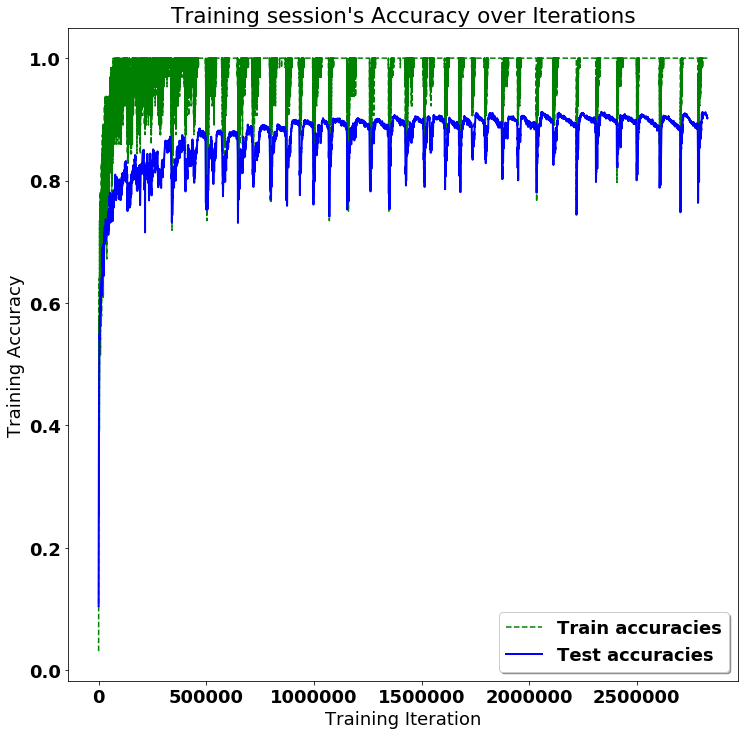

Testing Accuracy: 90.16194343566895%

Precision: 90.28691653830751%
Recall: 90.16194331983806%
f1_score: 90.09898310050977%

Confusion Matrix:
Created using test set of 2470 datapoints, normalised to % of each class in the test dataset


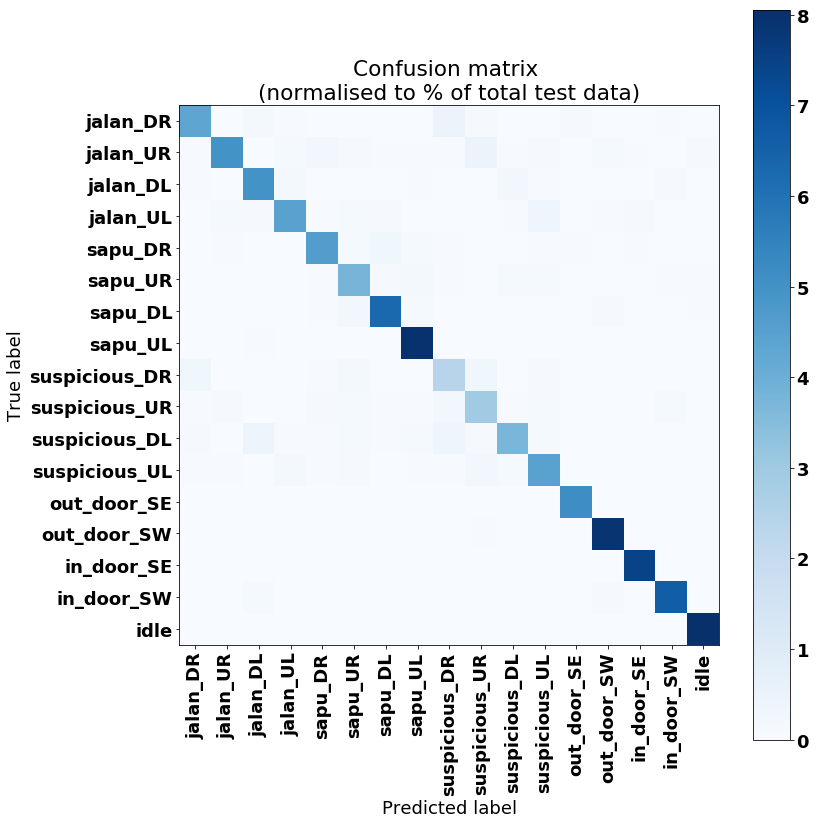

In [15]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
#plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
#plt.plot(indep_test_axis, np.array(test_losses), "b-", linewidth=2.0, label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "b-", linewidth=2.0, label="Test accuracies")
print(len(test_accuracies))
print(len(train_accuracies))

plt.title("Training session's Accuracy over Iterations")
plt.legend(loc='lower right', shadow=True)
plt.ylabel('Training Accuracy')
plt.xlabel('Training Iteration')

plt.show()

# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy_fin))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
print("Created using test set of {} datapoints, normalised to % of each class in the test dataset".format(len(y_test)))
confusion_matrix = metrics.confusion_matrix(y_test, predictions)


#print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100


# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.Blues
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [16]:


#
#X_val_path = DATASET_PATH + "X_val.txt"
#X_val = load_X(X_val_path)
#print X_val
#
#preds = sess.run(
#    [pred],
#    feed_dict={
#        x: X_val
#   }
#)
#
#print preds

In [17]:
#sess.close()
print(test_accuracies)

[0.1048583, 0.30850202, 0.3360324, 0.41093117, 0.46639675, 0.47732794, 0.51012146, 0.53562754, 0.54817814, 0.54048586, 0.5469636, 0.5708502, 0.5769231, 0.5834008, 0.58502024, 0.59352225, 0.58299595, 0.6068826, 0.6060729, 0.62591094, 0.5947368, 0.59838057, 0.62591094, 0.6210526, 0.62672067, 0.6291498, 0.6230769, 0.6404858, 0.6396761, 0.6125506, 0.64129555, 0.64534414, 0.62834007, 0.6554656, 0.69068825, 0.6700405, 0.65870446, 0.6631579, 0.6854251, 0.68218625, 0.69473684, 0.6951417, 0.68502027, 0.67368424, 0.66558707, 0.6748988, 0.6441296, 0.6785425, 0.6700405, 0.6744939, 0.68421054, 0.691498, 0.71417004, 0.6959514, 0.7182186, 0.7242915, 0.69757086, 0.71497977, 0.71214575, 0.72510123, 0.7109312, 0.708502, 0.7125506, 0.7259109, 0.7368421, 0.73360324, 0.7093117, 0.7089069, 0.70161945, 0.7182186, 0.7178138, 0.72672063, 0.7340081, 0.7137652, 0.7287449, 0.7271255, 0.71700406, 0.72064775, 0.7263158, 0.7234818, 0.73562753, 0.72307694, 0.7214575, 0.73157895, 0.7392713, 0.7465587, 0.7493927, 0.739

## Conclusion

Final accuracy of >90% is pretty good, considering that training takes about 7 minutes.

Noticeable confusion between activities of Clapping Hands and Boxing, and between Jumping Jacks and Waving Two Hands which is understandable.

In terms of the applicability of this to a wider dataset, I would imagine that it would be able to work for any activities in which the training included a views from all angles to be tested on. It would be interesting to see it's applicability to camera angles in between the 4 used in this dataset, without training on them specifically.

 Overall, this experiment validates the idea that 2D pose can be used for at least human activity recognition, and provides verification to continue onto use of 2D pose for behaviour estimation in both people and animals
 

 ### With regards to Using LSTM-RNNs
 - Batch sampling
     - It is neccessary to ensure you are not just sampling classes one at a time! (ie y_train is ordered by class and batch chosen in order)The use of random sampling of batches without replacement from the training data resolves this.    
 
 - Architecture
     - Testing has been run using a variety of hidden units per LSTM cell, with results showing that testing accuracy achieves a higher score when using a number of hidden cells approximately equal to that of the input, ie 34. The following figure displays the final accuracy achieved on the testing dataset for a variety of hidden units, all using a batch size of 4096 and 300 epochs (a total of 1657 iterations, with testing performed every 8th iteration).
   
 
 

## Future Works

Inclusion of :

 - A pipeline for qualitative results
 - A validation dataset
 - Momentum     
 - Normalise input data (each point with respect to distribution of itself only)
 - Dropout
 - Comparison of effect of changing batch size
 

Further research will be made into the use on more subtle activity classes, such as walking versus running, agitated movement versus calm movement, and perhaps normal versus abnormal behaviour, based on a baseline of normal motion.


## References

The dataset can be found at http://tele-immersion.citris-uc.org/berkeley_mhad released under the BSD-2 license
>Copyright (c) 2013, Regents of the University of California All rights reserved.

The network used in this experiment is based on the following, available under the [MIT License](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition/blob/master/LICENSE). :
> Guillaume Chevalier, LSTMs for Human Activity Recognition, 2016
> https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition



In [18]:
# Let's convert this notebook to a README for the GitHub project's title page:
!jupyter nbconvert --to markdown LSTM.ipynb
!mv LSTM.md README.md

[NbConvertApp] Converting notebook LSTM.ipynb to markdown
[NbConvertApp] Writing 945957 bytes to LSTM.md


## 

In [19]:
#### Camera

# import argparse
# import logging
# import time

# import cv2
# import numpy as np

# from tf_pose.estimator import TfPoseEstimator
# from tf_pose.networks import get_graph_path, model_wh

# logger = logging.getLogger('TfPoseEstimator-WebCam')
# logger.setLevel(logging.DEBUG)
# ch = logging.StreamHandler()
# ch.setLevel(logging.DEBUG)
# formatter = logging.Formatter('[%(asctime)s] [%(name)s] [%(levelname)s] %(message)s')
# ch.setFormatter(formatter)
# logger.addHandler(ch)

# class openpose:
#     def __init__(self, camera=0,resize='0x0',resize_out_ratio=4.0,model='mobilenet_thin',show_process=False):

#         logger.debug('initialization %s : %s' % (model, get_graph_path(model)))
#         w, h = model_wh(resize)
#         if w > 0 and h > 0:
#             e = TfPoseEstimator(get_graph_path(model), target_size=(w, h))
#         else:
#             e = TfPoseEstimator(get_graph_path(model), target_size=(432, 368))
#         logger.debug('cam read+')
#         cam = cv2.VideoCapture(camera)
#         ret_val, image = cam.read()
#         logger.info('cam image=%dx%d' % (image.shape[1], image.shape[0]))
        
#         fps_time = 0

#         while True:
#             ret_val, image = cam.read()

#             logger.debug('image process+')
#             humans = e.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)

#             logger.debug('postprocess+')
#             image = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)

#             logger.debug('show+')
#             cv2.putText(image,
#                         "FPS: %f" % (1.0 / (time.time() - fps_time)),
#                         (10, 10),  cv2.FONT_HERSHEY_SIMPLEX, 0.5,
#                         (0, 255, 0), 2)
#             cv2.imshow('tf-pose-estimation result', image)
#             fps_time = time.time()
#             if cv2.waitKey(1) == 27:
#                 break
#             logger.debug('finished+')

#         cv2.destroyAllWindows()

# if __name__ == '__main__':
#     openpose()
